In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
import numpy as np
from util import getHashId, pickleLoad

feature_selection = pickleLoad('data/feature_selection.pkl')
features_oc = np.load('data/preprocessed/features_vox.npy')
exc = 40
features = [f for f in features_oc if f not in feature_selection['excludeds'][exc][np.argmax(feature_selection['accuracies'][exc])]]

props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : features,
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_1_t1t2_normalized_e_n_glcm_JointEntropy_glcm_Id_glcm_Idn_glcm_InverseVariance_glcm_MaximumProbability_glcm_SumEntropy_glcm_SumSquares_glszm_SmallAreaEmphasis_glszm_LargeAreaEmphasis_glszm_GrayLevelNonUniformity_glszm_GrayLevelNonUniformityNormalized_glszm_SizeZoneNonUniformity_glszm_SizeZoneNonUniformityNormalized_glszm_ZonePercentage_glszm_GrayLevelVariance_glszm_ZoneEntropy_glszm_HighGrayLevelZoneEmphasis_glszm_LargeAreaLowGrayLevelEmphasis_glszm_LargeAreaHighGrayLevelEmphasis_glrlm_ShortRunEmphasis_glrlm_LongRunEmphasis_glrlm_GrayLevelNonUniformity_glrlm_GrayLevelNonUniformityNormalized_glrlm_RunLengthNonUniformity_glrlm_RunLengthNonUniformityNormalized_glrlm_RunPercentage_glrlm_GrayLevelVariance_glrlm_RunEntropy_glrlm_LowGrayLevelRunEmphasis_glrlm_HighGrayLevelRunEmphasis_glrlm_ShortRunLowGrayLevelEmphasis_glrlm_ShortRunHighGrayLevelEmphasis_glrlm_LongRunLowGrayLevelEmphasis_glrlm_LongRunHighGrayLevelEmphasis_ngtdm_Coarseness_ngtdm_

In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(4629816, 468)
(4629816, 8)
validation
(621056, 468)
(621056, 8)
test
(624904, 468)
(624904, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 468)]             0         


 dense (Dense)               (None, 1024)              480256    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1170312 (4.46 MB)


Trainable params: 1170312 (4.46 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/463 [..............................] - ETA: 10:11 - loss: 2.4550 - STD: 0.1042 - MAE: 0.2208

  6/463 [..............................] - ETA: 5s - loss: 2.1649 - STD: 0.0579 - MAE: 0.2176   

 11/463 [..............................] - ETA: 5s - loss: 2.1321 - STD: 0.0568 - MAE: 0.2168

 15/463 [..............................] - ETA: 5s - loss: 2.1165 - STD: 0.0530 - MAE: 0.2167

 20/463 [>.............................] - ETA: 5s - loss: 2.1007 - STD: 0.0487 - MAE: 0.2167

 25/463 [>.............................] - ETA: 5s - loss: 2.0919 - STD: 0.0447 - MAE: 0.2167

 30/463 [>.............................] - ETA: 5s - loss: 2.0856 - STD: 0.0421 - MAE: 0.2168

 35/463 [=>............................] - ETA: 5s - loss: 2.0806 - STD: 0.0411 - MAE: 0.2167

 39/463 [=>............................] - ETA: 5s - loss: 2.0773 - STD: 0.0403 - MAE: 0.2167

 44/463 [=>............................] - ETA: 5s - loss: 2.0739 - STD: 0.0397 - MAE: 0.2167

 49/463 [==>...........................] - ETA: 5s - loss: 2.0708 - STD: 0.0388 - MAE: 0.2167

 54/463 [==>...........................] - ETA: 5s - loss: 2.0676 - STD: 0.0380 - MAE: 0.2166

 59/463 [==>...........................] - ETA: 4s - loss: 2.0635 - STD: 0.0375 - MAE: 0.2165

 64/463 [===>..........................] - ETA: 4s - loss: 2.0579 - STD: 0.0375 - MAE: 0.2164

 69/463 [===>..........................] - ETA: 4s - loss: 2.0504 - STD: 0.0379 - MAE: 0.2161

 74/463 [===>..........................] - ETA: 4s - loss: 2.0409 - STD: 0.0390 - MAE: 0.2158

 79/463 [====>.........................] - ETA: 4s - loss: 2.0297 - STD: 0.0406 - MAE: 0.2153

 84/463 [====>.........................] - ETA: 4s - loss: 2.0168 - STD: 0.0423 - MAE: 0.2147

 89/463 [====>.........................] - ETA: 4s - loss: 2.0019 - STD: 0.0442 - MAE: 0.2141

 94/463 [=====>........................] - ETA: 4s - loss: 1.9858 - STD: 0.0464 - MAE: 0.2133

 99/463 [=====>........................] - ETA: 4s - loss: 1.9690 - STD: 0.0489 - MAE: 0.2125

104/463 [=====>........................] - ETA: 4s - loss: 1.9522 - STD: 0.0515 - MAE: 0.2116

109/463 [======>.......................] - ETA: 4s - loss: 1.9355 - STD: 0.0542 - MAE: 0.2106

114/463 [======>.......................] - ETA: 4s - loss: 1.9194 - STD: 0.0569 - MAE: 0.2097

119/463 [======>.......................] - ETA: 4s - loss: 1.9034 - STD: 0.0594 - MAE: 0.2087

124/463 [=======>......................] - ETA: 4s - loss: 1.8881 - STD: 0.0620 - MAE: 0.2078

129/463 [=======>......................] - ETA: 4s - loss: 1.8730 - STD: 0.0644 - MAE: 0.2069

134/463 [=======>......................] - ETA: 3s - loss: 1.8582 - STD: 0.0669 - MAE: 0.2059

139/463 [========>.....................] - ETA: 3s - loss: 1.8436 - STD: 0.0693 - MAE: 0.2050

144/463 [========>.....................] - ETA: 3s - loss: 1.8295 - STD: 0.0716 - MAE: 0.2040

149/463 [========>.....................] - ETA: 3s - loss: 1.8156 - STD: 0.0739 - MAE: 0.2031

154/463 [========>.....................] - ETA: 3s - loss: 1.8021 - STD: 0.0761 - MAE: 0.2022

159/463 [=========>....................] - ETA: 3s - loss: 1.7894 - STD: 0.0783 - MAE: 0.2013

163/463 [=========>....................] - ETA: 3s - loss: 1.7794 - STD: 0.0800 - MAE: 0.2006

167/463 [=========>....................] - ETA: 3s - loss: 1.7695 - STD: 0.0817 - MAE: 0.1999

171/463 [==========>...................] - ETA: 3s - loss: 1.7598 - STD: 0.0832 - MAE: 0.1992

175/463 [==========>...................] - ETA: 3s - loss: 1.7506 - STD: 0.0848 - MAE: 0.1986

179/463 [==========>...................] - ETA: 3s - loss: 1.7415 - STD: 0.0863 - MAE: 0.1979

184/463 [==========>...................] - ETA: 3s - loss: 1.7305 - STD: 0.0881 - MAE: 0.1971

189/463 [===========>..................] - ETA: 3s - loss: 1.7198 - STD: 0.0899 - MAE: 0.1963

194/463 [===========>..................] - ETA: 3s - loss: 1.7093 - STD: 0.0916 - MAE: 0.1956

199/463 [===========>..................] - ETA: 3s - loss: 1.6992 - STD: 0.0933 - MAE: 0.1948

203/463 [============>.................] - ETA: 3s - loss: 1.6915 - STD: 0.0946 - MAE: 0.1942

208/463 [============>.................] - ETA: 3s - loss: 1.6821 - STD: 0.0962 - MAE: 0.1935

213/463 [============>.................] - ETA: 3s - loss: 1.6731 - STD: 0.0977 - MAE: 0.1929

218/463 [=============>................] - ETA: 2s - loss: 1.6643 - STD: 0.0992 - MAE: 0.1922

223/463 [=============>................] - ETA: 2s - loss: 1.6557 - STD: 0.1006 - MAE: 0.1915

228/463 [=============>................] - ETA: 2s - loss: 1.6475 - STD: 0.1020 - MAE: 0.1909

232/463 [==============>...............] - ETA: 2s - loss: 1.6411 - STD: 0.1031 - MAE: 0.1904

237/463 [==============>...............] - ETA: 2s - loss: 1.6331 - STD: 0.1044 - MAE: 0.1898

242/463 [==============>...............] - ETA: 2s - loss: 1.6256 - STD: 0.1057 - MAE: 0.1892

247/463 [===============>..............] - ETA: 2s - loss: 1.6181 - STD: 0.1070 - MAE: 0.1886

252/463 [===============>..............] - ETA: 2s - loss: 1.6109 - STD: 0.1082 - MAE: 0.1880

256/463 [===============>..............] - ETA: 2s - loss: 1.6053 - STD: 0.1091 - MAE: 0.1876

261/463 [===============>..............] - ETA: 2s - loss: 1.5984 - STD: 0.1103 - MAE: 0.1870

266/463 [================>.............] - ETA: 2s - loss: 1.5918 - STD: 0.1114 - MAE: 0.1865

271/463 [================>.............] - ETA: 2s - loss: 1.5855 - STD: 0.1125 - MAE: 0.1860

276/463 [================>.............] - ETA: 2s - loss: 1.5792 - STD: 0.1136 - MAE: 0.1855

280/463 [=================>............] - ETA: 2s - loss: 1.5744 - STD: 0.1144 - MAE: 0.1851

285/463 [=================>............] - ETA: 2s - loss: 1.5685 - STD: 0.1154 - MAE: 0.1846

290/463 [=================>............] - ETA: 2s - loss: 1.5627 - STD: 0.1164 - MAE: 0.1841

295/463 [==================>...........] - ETA: 2s - loss: 1.5570 - STD: 0.1174 - MAE: 0.1837

300/463 [==================>...........] - ETA: 1s - loss: 1.5516 - STD: 0.1183 - MAE: 0.1832

305/463 [==================>...........] - ETA: 1s - loss: 1.5464 - STD: 0.1192 - MAE: 0.1828

309/463 [===================>..........] - ETA: 1s - loss: 1.5423 - STD: 0.1199 - MAE: 0.1824

314/463 [===================>..........] - ETA: 1s - loss: 1.5372 - STD: 0.1208 - MAE: 0.1820

319/463 [===================>..........] - ETA: 1s - loss: 1.5323 - STD: 0.1216 - MAE: 0.1816

324/463 [===================>..........] - ETA: 1s - loss: 1.5273 - STD: 0.1225 - MAE: 0.1812

329/463 [====================>.........] - ETA: 1s - loss: 1.5225 - STD: 0.1233 - MAE: 0.1808

333/463 [====================>.........] - ETA: 1s - loss: 1.5189 - STD: 0.1239 - MAE: 0.1805

338/463 [====================>.........] - ETA: 1s - loss: 1.5144 - STD: 0.1247 - MAE: 0.1801

343/463 [=====================>........] - ETA: 1s - loss: 1.5100 - STD: 0.1254 - MAE: 0.1798

348/463 [=====================>........] - ETA: 1s - loss: 1.5057 - STD: 0.1262 - MAE: 0.1794

352/463 [=====================>........] - ETA: 1s - loss: 1.5022 - STD: 0.1268 - MAE: 0.1791

356/463 [======================>.......] - ETA: 1s - loss: 1.4990 - STD: 0.1273 - MAE: 0.1788

361/463 [======================>.......] - ETA: 1s - loss: 1.4948 - STD: 0.1280 - MAE: 0.1785

366/463 [======================>.......] - ETA: 1s - loss: 1.4909 - STD: 0.1287 - MAE: 0.1782

371/463 [=======================>......] - ETA: 1s - loss: 1.4870 - STD: 0.1294 - MAE: 0.1778

373/463 [=======================>......] - ETA: 1s - loss: 1.4854 - STD: 0.1296 - MAE: 0.1777

378/463 [=======================>......] - ETA: 1s - loss: 1.4816 - STD: 0.1303 - MAE: 0.1774

383/463 [=======================>......] - ETA: 1s - loss: 1.4779 - STD: 0.1309 - MAE: 0.1771

387/463 [========================>.....] - ETA: 1s - loss: 1.4749 - STD: 0.1314 - MAE: 0.1768

392/463 [========================>.....] - ETA: 0s - loss: 1.4713 - STD: 0.1320 - MAE: 0.1765

397/463 [========================>.....] - ETA: 0s - loss: 1.4677 - STD: 0.1326 - MAE: 0.1762

402/463 [=========================>....] - ETA: 0s - loss: 1.4641 - STD: 0.1332 - MAE: 0.1759

407/463 [=========================>....] - ETA: 0s - loss: 1.4607 - STD: 0.1338 - MAE: 0.1756

412/463 [=========================>....] - ETA: 0s - loss: 1.4574 - STD: 0.1344 - MAE: 0.1753

417/463 [==========================>...] - ETA: 0s - loss: 1.4540 - STD: 0.1349 - MAE: 0.1750

422/463 [==========================>...] - ETA: 0s - loss: 1.4507 - STD: 0.1355 - MAE: 0.1747

427/463 [==========================>...] - ETA: 0s - loss: 1.4476 - STD: 0.1360 - MAE: 0.1745

432/463 [==========================>...] - ETA: 0s - loss: 1.4445 - STD: 0.1366 - MAE: 0.1742

436/463 [===========================>..] - ETA: 0s - loss: 1.4420 - STD: 0.1370 - MAE: 0.1740

441/463 [===========================>..] - ETA: 0s - loss: 1.4389 - STD: 0.1375 - MAE: 0.1737

446/463 [===========================>..] - ETA: 0s - loss: 1.4359 - STD: 0.1380 - MAE: 0.1735

451/463 [============================>.] - ETA: 0s - loss: 1.4330 - STD: 0.1385 - MAE: 0.1732

456/463 [============================>.] - ETA: 0s - loss: 1.4301 - STD: 0.1390 - MAE: 0.1730

461/463 [============================>.] - ETA: 0s - loss: 1.4272 - STD: 0.1394 - MAE: 0.1727

463/463 [==============================] - 9s 16ms/step - loss: 1.4261 - STD: 0.1396 - MAE: 0.1726 - val_loss: 1.2552 - val_STD: 0.1805 - val_MAE: 0.1552


Epoch 2/10000


  1/463 [..............................] - ETA: 17s - loss: 1.1539 - STD: 0.1838 - MAE: 0.1488

  5/463 [..............................] - ETA: 5s - loss: 1.1597 - STD: 0.1839 - MAE: 0.1494 

 10/463 [..............................] - ETA: 5s - loss: 1.1594 - STD: 0.1838 - MAE: 0.1495

 15/463 [..............................] - ETA: 5s - loss: 1.1593 - STD: 0.1840 - MAE: 0.1494

 20/463 [>.............................] - ETA: 5s - loss: 1.1583 - STD: 0.1842 - MAE: 0.1493

 25/463 [>.............................] - ETA: 5s - loss: 1.1571 - STD: 0.1844 - MAE: 0.1491

 29/463 [>.............................] - ETA: 5s - loss: 1.1566 - STD: 0.1846 - MAE: 0.1490

 34/463 [=>............................] - ETA: 5s - loss: 1.1559 - STD: 0.1846 - MAE: 0.1490

 39/463 [=>............................] - ETA: 5s - loss: 1.1586 - STD: 0.1848 - MAE: 0.1490

 44/463 [=>............................] - ETA: 5s - loss: 1.1596 - STD: 0.1847 - MAE: 0.1491

 49/463 [==>...........................] - ETA: 5s - loss: 1.1585 - STD: 0.1847 - MAE: 0.1490

 53/463 [==>...........................] - ETA: 4s - loss: 1.1575 - STD: 0.1849 - MAE: 0.1489

 58/463 [==>...........................] - ETA: 4s - loss: 1.1574 - STD: 0.1851 - MAE: 0.1488

 63/463 [===>..........................] - ETA: 4s - loss: 1.1560 - STD: 0.1852 - MAE: 0.1487

 68/463 [===>..........................] - ETA: 4s - loss: 1.1545 - STD: 0.1853 - MAE: 0.1486

 73/463 [===>..........................] - ETA: 4s - loss: 1.1535 - STD: 0.1855 - MAE: 0.1485

 77/463 [===>..........................] - ETA: 4s - loss: 1.1529 - STD: 0.1856 - MAE: 0.1484

 82/463 [====>.........................] - ETA: 4s - loss: 1.1521 - STD: 0.1857 - MAE: 0.1483

 87/463 [====>.........................] - ETA: 4s - loss: 1.1511 - STD: 0.1859 - MAE: 0.1482

 92/463 [====>.........................] - ETA: 4s - loss: 1.1506 - STD: 0.1860 - MAE: 0.1481

 97/463 [=====>........................] - ETA: 4s - loss: 1.1499 - STD: 0.1861 - MAE: 0.1481

102/463 [=====>........................] - ETA: 4s - loss: 1.1492 - STD: 0.1862 - MAE: 0.1480

107/463 [=====>........................] - ETA: 4s - loss: 1.1483 - STD: 0.1864 - MAE: 0.1479

112/463 [======>.......................] - ETA: 4s - loss: 1.1473 - STD: 0.1865 - MAE: 0.1478

117/463 [======>.......................] - ETA: 4s - loss: 1.1467 - STD: 0.1866 - MAE: 0.1477

122/463 [======>.......................] - ETA: 4s - loss: 1.1462 - STD: 0.1867 - MAE: 0.1477

126/463 [=======>......................] - ETA: 4s - loss: 1.1455 - STD: 0.1867 - MAE: 0.1476

131/463 [=======>......................] - ETA: 4s - loss: 1.1450 - STD: 0.1868 - MAE: 0.1476

136/463 [=======>......................] - ETA: 3s - loss: 1.1442 - STD: 0.1869 - MAE: 0.1475

141/463 [========>.....................] - ETA: 3s - loss: 1.1436 - STD: 0.1870 - MAE: 0.1474

146/463 [========>.....................] - ETA: 3s - loss: 1.1430 - STD: 0.1872 - MAE: 0.1473

151/463 [========>.....................] - ETA: 3s - loss: 1.1421 - STD: 0.1873 - MAE: 0.1472

155/463 [=========>....................] - ETA: 3s - loss: 1.1413 - STD: 0.1874 - MAE: 0.1471

160/463 [=========>....................] - ETA: 3s - loss: 1.1403 - STD: 0.1875 - MAE: 0.1470

165/463 [=========>....................] - ETA: 3s - loss: 1.1397 - STD: 0.1876 - MAE: 0.1470

170/463 [==========>...................] - ETA: 3s - loss: 1.1395 - STD: 0.1877 - MAE: 0.1469

175/463 [==========>...................] - ETA: 3s - loss: 1.1393 - STD: 0.1878 - MAE: 0.1469

179/463 [==========>...................] - ETA: 3s - loss: 1.1388 - STD: 0.1878 - MAE: 0.1468

184/463 [==========>...................] - ETA: 3s - loss: 1.1381 - STD: 0.1879 - MAE: 0.1467

189/463 [===========>..................] - ETA: 3s - loss: 1.1373 - STD: 0.1880 - MAE: 0.1467

194/463 [===========>..................] - ETA: 3s - loss: 1.1363 - STD: 0.1881 - MAE: 0.1466

199/463 [===========>..................] - ETA: 3s - loss: 1.1354 - STD: 0.1882 - MAE: 0.1465

204/463 [============>.................] - ETA: 3s - loss: 1.1345 - STD: 0.1883 - MAE: 0.1464

209/463 [============>.................] - ETA: 3s - loss: 1.1336 - STD: 0.1884 - MAE: 0.1463

214/463 [============>.................] - ETA: 3s - loss: 1.1329 - STD: 0.1886 - MAE: 0.1462

219/463 [=============>................] - ETA: 2s - loss: 1.1323 - STD: 0.1887 - MAE: 0.1462

224/463 [=============>................] - ETA: 2s - loss: 1.1317 - STD: 0.1888 - MAE: 0.1461

229/463 [=============>................] - ETA: 2s - loss: 1.1311 - STD: 0.1888 - MAE: 0.1460

234/463 [==============>...............] - ETA: 2s - loss: 1.1303 - STD: 0.1889 - MAE: 0.1459

238/463 [==============>...............] - ETA: 2s - loss: 1.1298 - STD: 0.1890 - MAE: 0.1459

243/463 [==============>...............] - ETA: 2s - loss: 1.1291 - STD: 0.1891 - MAE: 0.1458

248/463 [===============>..............] - ETA: 2s - loss: 1.1282 - STD: 0.1892 - MAE: 0.1457

253/463 [===============>..............] - ETA: 2s - loss: 1.1276 - STD: 0.1893 - MAE: 0.1456

258/463 [===============>..............] - ETA: 2s - loss: 1.1269 - STD: 0.1894 - MAE: 0.1456

262/463 [===============>..............] - ETA: 2s - loss: 1.1264 - STD: 0.1895 - MAE: 0.1455

267/463 [================>.............] - ETA: 2s - loss: 1.1259 - STD: 0.1896 - MAE: 0.1454

272/463 [================>.............] - ETA: 2s - loss: 1.1254 - STD: 0.1897 - MAE: 0.1454

277/463 [================>.............] - ETA: 2s - loss: 1.1250 - STD: 0.1898 - MAE: 0.1453

282/463 [=================>............] - ETA: 2s - loss: 1.1244 - STD: 0.1898 - MAE: 0.1453

286/463 [=================>............] - ETA: 2s - loss: 1.1241 - STD: 0.1899 - MAE: 0.1452

290/463 [=================>............] - ETA: 2s - loss: 1.1237 - STD: 0.1900 - MAE: 0.1452

295/463 [==================>...........] - ETA: 2s - loss: 1.1231 - STD: 0.1901 - MAE: 0.1451

300/463 [==================>...........] - ETA: 1s - loss: 1.1226 - STD: 0.1901 - MAE: 0.1450

305/463 [==================>...........] - ETA: 1s - loss: 1.1220 - STD: 0.1902 - MAE: 0.1450

310/463 [===================>..........] - ETA: 1s - loss: 1.1214 - STD: 0.1903 - MAE: 0.1449

314/463 [===================>..........] - ETA: 1s - loss: 1.1210 - STD: 0.1904 - MAE: 0.1449

319/463 [===================>..........] - ETA: 1s - loss: 1.1205 - STD: 0.1905 - MAE: 0.1448

324/463 [===================>..........] - ETA: 1s - loss: 1.1200 - STD: 0.1906 - MAE: 0.1447

329/463 [====================>.........] - ETA: 1s - loss: 1.1196 - STD: 0.1906 - MAE: 0.1447

334/463 [====================>.........] - ETA: 1s - loss: 1.1191 - STD: 0.1907 - MAE: 0.1446

339/463 [====================>.........] - ETA: 1s - loss: 1.1188 - STD: 0.1908 - MAE: 0.1446

343/463 [=====================>........] - ETA: 1s - loss: 1.1185 - STD: 0.1909 - MAE: 0.1445

348/463 [=====================>........] - ETA: 1s - loss: 1.1179 - STD: 0.1909 - MAE: 0.1445

353/463 [=====================>........] - ETA: 1s - loss: 1.1174 - STD: 0.1910 - MAE: 0.1444

358/463 [======================>.......] - ETA: 1s - loss: 1.1168 - STD: 0.1911 - MAE: 0.1444

363/463 [======================>.......] - ETA: 1s - loss: 1.1162 - STD: 0.1912 - MAE: 0.1443

368/463 [======================>.......] - ETA: 1s - loss: 1.1156 - STD: 0.1912 - MAE: 0.1442

373/463 [=======================>......] - ETA: 1s - loss: 1.1151 - STD: 0.1913 - MAE: 0.1442

378/463 [=======================>......] - ETA: 1s - loss: 1.1147 - STD: 0.1914 - MAE: 0.1441

383/463 [=======================>......] - ETA: 0s - loss: 1.1142 - STD: 0.1915 - MAE: 0.1441

388/463 [========================>.....] - ETA: 0s - loss: 1.1138 - STD: 0.1915 - MAE: 0.1440

393/463 [========================>.....] - ETA: 0s - loss: 1.1132 - STD: 0.1916 - MAE: 0.1440

398/463 [========================>.....] - ETA: 0s - loss: 1.1126 - STD: 0.1917 - MAE: 0.1439

403/463 [=========================>....] - ETA: 0s - loss: 1.1119 - STD: 0.1917 - MAE: 0.1438

408/463 [=========================>....] - ETA: 0s - loss: 1.1113 - STD: 0.1918 - MAE: 0.1438

413/463 [=========================>....] - ETA: 0s - loss: 1.1108 - STD: 0.1919 - MAE: 0.1437

418/463 [==========================>...] - ETA: 0s - loss: 1.1102 - STD: 0.1920 - MAE: 0.1436

422/463 [==========================>...] - ETA: 0s - loss: 1.1097 - STD: 0.1920 - MAE: 0.1436

427/463 [==========================>...] - ETA: 0s - loss: 1.1092 - STD: 0.1921 - MAE: 0.1435

432/463 [==========================>...] - ETA: 0s - loss: 1.1086 - STD: 0.1922 - MAE: 0.1435

437/463 [===========================>..] - ETA: 0s - loss: 1.1082 - STD: 0.1923 - MAE: 0.1434

442/463 [===========================>..] - ETA: 0s - loss: 1.1076 - STD: 0.1924 - MAE: 0.1433

447/463 [===========================>..] - ETA: 0s - loss: 1.1070 - STD: 0.1924 - MAE: 0.1433

452/463 [============================>.] - ETA: 0s - loss: 1.1064 - STD: 0.1925 - MAE: 0.1432

457/463 [============================>.] - ETA: 0s - loss: 1.1058 - STD: 0.1926 - MAE: 0.1432

462/463 [============================>.] - ETA: 0s - loss: 1.1052 - STD: 0.1927 - MAE: 0.1431

463/463 [==============================] - 6s 13ms/step - loss: 1.1050 - STD: 0.1927 - MAE: 0.1431 - val_loss: 1.1755 - val_STD: 0.1960 - val_MAE: 0.1452


Epoch 3/10000


  1/463 [..............................] - ETA: 18s - loss: 1.0630 - STD: 0.2015 - MAE: 0.1369

  5/463 [..............................] - ETA: 5s - loss: 1.0540 - STD: 0.2007 - MAE: 0.1370 

 10/463 [..............................] - ETA: 5s - loss: 1.0574 - STD: 0.2004 - MAE: 0.1373

 15/463 [..............................] - ETA: 5s - loss: 1.0568 - STD: 0.1999 - MAE: 0.1375

 20/463 [>.............................] - ETA: 5s - loss: 1.0538 - STD: 0.2004 - MAE: 0.1371

 25/463 [>.............................] - ETA: 5s - loss: 1.0525 - STD: 0.2003 - MAE: 0.1371

 30/463 [>.............................] - ETA: 5s - loss: 1.0517 - STD: 0.2004 - MAE: 0.1370

 35/463 [=>............................] - ETA: 5s - loss: 1.0510 - STD: 0.2005 - MAE: 0.1369

 40/463 [=>............................] - ETA: 5s - loss: 1.0505 - STD: 0.2006 - MAE: 0.1368

 45/463 [=>............................] - ETA: 5s - loss: 1.0501 - STD: 0.2006 - MAE: 0.1368

 50/463 [==>...........................] - ETA: 5s - loss: 1.0506 - STD: 0.2008 - MAE: 0.1368

 54/463 [==>...........................] - ETA: 4s - loss: 1.0499 - STD: 0.2008 - MAE: 0.1368

 58/463 [==>...........................] - ETA: 4s - loss: 1.0506 - STD: 0.2009 - MAE: 0.1368

 62/463 [===>..........................] - ETA: 4s - loss: 1.0508 - STD: 0.2009 - MAE: 0.1368

 67/463 [===>..........................] - ETA: 4s - loss: 1.0509 - STD: 0.2009 - MAE: 0.1368

 72/463 [===>..........................] - ETA: 4s - loss: 1.0511 - STD: 0.2009 - MAE: 0.1368

 77/463 [===>..........................] - ETA: 4s - loss: 1.0511 - STD: 0.2010 - MAE: 0.1368

 82/463 [====>.........................] - ETA: 4s - loss: 1.0501 - STD: 0.2011 - MAE: 0.1367

 87/463 [====>.........................] - ETA: 4s - loss: 1.0492 - STD: 0.2011 - MAE: 0.1366

 92/463 [====>.........................] - ETA: 4s - loss: 1.0480 - STD: 0.2012 - MAE: 0.1365

 97/463 [=====>........................] - ETA: 4s - loss: 1.0475 - STD: 0.2012 - MAE: 0.1365

102/463 [=====>........................] - ETA: 4s - loss: 1.0486 - STD: 0.2013 - MAE: 0.1365

106/463 [=====>........................] - ETA: 4s - loss: 1.0494 - STD: 0.2014 - MAE: 0.1365

111/463 [======>.......................] - ETA: 4s - loss: 1.0500 - STD: 0.2014 - MAE: 0.1365

116/463 [======>.......................] - ETA: 4s - loss: 1.0504 - STD: 0.2014 - MAE: 0.1366

121/463 [======>.......................] - ETA: 4s - loss: 1.0503 - STD: 0.2014 - MAE: 0.1365

126/463 [=======>......................] - ETA: 4s - loss: 1.0504 - STD: 0.2014 - MAE: 0.1365

131/463 [=======>......................] - ETA: 4s - loss: 1.0499 - STD: 0.2014 - MAE: 0.1365

135/463 [=======>......................] - ETA: 3s - loss: 1.0494 - STD: 0.2014 - MAE: 0.1365

140/463 [========>.....................] - ETA: 3s - loss: 1.0487 - STD: 0.2015 - MAE: 0.1364

145/463 [========>.....................] - ETA: 3s - loss: 1.0481 - STD: 0.2015 - MAE: 0.1364

150/463 [========>.....................] - ETA: 3s - loss: 1.0475 - STD: 0.2016 - MAE: 0.1363

155/463 [=========>....................] - ETA: 3s - loss: 1.0469 - STD: 0.2016 - MAE: 0.1363

160/463 [=========>....................] - ETA: 3s - loss: 1.0466 - STD: 0.2017 - MAE: 0.1362

164/463 [=========>....................] - ETA: 3s - loss: 1.0462 - STD: 0.2017 - MAE: 0.1362

169/463 [=========>....................] - ETA: 3s - loss: 1.0460 - STD: 0.2018 - MAE: 0.1361

174/463 [==========>...................] - ETA: 3s - loss: 1.0457 - STD: 0.2019 - MAE: 0.1361

179/463 [==========>...................] - ETA: 3s - loss: 1.0451 - STD: 0.2019 - MAE: 0.1360

184/463 [==========>...................] - ETA: 3s - loss: 1.0445 - STD: 0.2019 - MAE: 0.1360

188/463 [===========>..................] - ETA: 3s - loss: 1.0443 - STD: 0.2020 - MAE: 0.1360

192/463 [===========>..................] - ETA: 3s - loss: 1.0439 - STD: 0.2020 - MAE: 0.1359

197/463 [===========>..................] - ETA: 3s - loss: 1.0435 - STD: 0.2021 - MAE: 0.1359

202/463 [============>.................] - ETA: 3s - loss: 1.0431 - STD: 0.2021 - MAE: 0.1358

207/463 [============>.................] - ETA: 3s - loss: 1.0427 - STD: 0.2022 - MAE: 0.1358

211/463 [============>.................] - ETA: 3s - loss: 1.0424 - STD: 0.2022 - MAE: 0.1357

216/463 [============>.................] - ETA: 3s - loss: 1.0419 - STD: 0.2023 - MAE: 0.1357

221/463 [=============>................] - ETA: 2s - loss: 1.0414 - STD: 0.2024 - MAE: 0.1357

226/463 [=============>................] - ETA: 2s - loss: 1.0409 - STD: 0.2024 - MAE: 0.1356

230/463 [=============>................] - ETA: 2s - loss: 1.0404 - STD: 0.2025 - MAE: 0.1355

234/463 [==============>...............] - ETA: 2s - loss: 1.0399 - STD: 0.2025 - MAE: 0.1355

238/463 [==============>...............] - ETA: 2s - loss: 1.0395 - STD: 0.2025 - MAE: 0.1355

243/463 [==============>...............] - ETA: 2s - loss: 1.0390 - STD: 0.2026 - MAE: 0.1354

248/463 [===============>..............] - ETA: 2s - loss: 1.0385 - STD: 0.2027 - MAE: 0.1354

253/463 [===============>..............] - ETA: 2s - loss: 1.0380 - STD: 0.2027 - MAE: 0.1353

258/463 [===============>..............] - ETA: 2s - loss: 1.0379 - STD: 0.2028 - MAE: 0.1353

262/463 [===============>..............] - ETA: 2s - loss: 1.0378 - STD: 0.2029 - MAE: 0.1352

267/463 [================>.............] - ETA: 2s - loss: 1.0378 - STD: 0.2029 - MAE: 0.1352

272/463 [================>.............] - ETA: 2s - loss: 1.0373 - STD: 0.2030 - MAE: 0.1352

277/463 [================>.............] - ETA: 2s - loss: 1.0369 - STD: 0.2030 - MAE: 0.1351

282/463 [=================>............] - ETA: 2s - loss: 1.0365 - STD: 0.2031 - MAE: 0.1351

287/463 [=================>............] - ETA: 2s - loss: 1.0364 - STD: 0.2031 - MAE: 0.1351

292/463 [=================>............] - ETA: 2s - loss: 1.0358 - STD: 0.2032 - MAE: 0.1350

297/463 [==================>...........] - ETA: 2s - loss: 1.0353 - STD: 0.2032 - MAE: 0.1350

302/463 [==================>...........] - ETA: 1s - loss: 1.0348 - STD: 0.2033 - MAE: 0.1349

307/463 [==================>...........] - ETA: 1s - loss: 1.0343 - STD: 0.2033 - MAE: 0.1349

312/463 [===================>..........] - ETA: 1s - loss: 1.0338 - STD: 0.2034 - MAE: 0.1348

317/463 [===================>..........] - ETA: 1s - loss: 1.0332 - STD: 0.2034 - MAE: 0.1347

322/463 [===================>..........] - ETA: 1s - loss: 1.0328 - STD: 0.2035 - MAE: 0.1347

327/463 [====================>.........] - ETA: 1s - loss: 1.0323 - STD: 0.2036 - MAE: 0.1347

332/463 [====================>.........] - ETA: 1s - loss: 1.0317 - STD: 0.2036 - MAE: 0.1346

337/463 [====================>.........] - ETA: 1s - loss: 1.0314 - STD: 0.2037 - MAE: 0.1346

342/463 [=====================>........] - ETA: 1s - loss: 1.0309 - STD: 0.2037 - MAE: 0.1345

347/463 [=====================>........] - ETA: 1s - loss: 1.0305 - STD: 0.2038 - MAE: 0.1345

352/463 [=====================>........] - ETA: 1s - loss: 1.0301 - STD: 0.2038 - MAE: 0.1344

357/463 [======================>.......] - ETA: 1s - loss: 1.0297 - STD: 0.2039 - MAE: 0.1344

362/463 [======================>.......] - ETA: 1s - loss: 1.0293 - STD: 0.2039 - MAE: 0.1343

366/463 [======================>.......] - ETA: 1s - loss: 1.0291 - STD: 0.2040 - MAE: 0.1343

371/463 [=======================>......] - ETA: 1s - loss: 1.0289 - STD: 0.2040 - MAE: 0.1343

376/463 [=======================>......] - ETA: 1s - loss: 1.0286 - STD: 0.2041 - MAE: 0.1342

381/463 [=======================>......] - ETA: 0s - loss: 1.0284 - STD: 0.2042 - MAE: 0.1342

386/463 [========================>.....] - ETA: 0s - loss: 1.0280 - STD: 0.2042 - MAE: 0.1341

391/463 [========================>.....] - ETA: 0s - loss: 1.0276 - STD: 0.2043 - MAE: 0.1341

395/463 [========================>.....] - ETA: 0s - loss: 1.0274 - STD: 0.2043 - MAE: 0.1341

400/463 [========================>.....] - ETA: 0s - loss: 1.0270 - STD: 0.2043 - MAE: 0.1340

405/463 [=========================>....] - ETA: 0s - loss: 1.0267 - STD: 0.2044 - MAE: 0.1340

410/463 [=========================>....] - ETA: 0s - loss: 1.0263 - STD: 0.2044 - MAE: 0.1340

415/463 [=========================>....] - ETA: 0s - loss: 1.0259 - STD: 0.2045 - MAE: 0.1339

419/463 [==========================>...] - ETA: 0s - loss: 1.0256 - STD: 0.2045 - MAE: 0.1339

424/463 [==========================>...] - ETA: 0s - loss: 1.0252 - STD: 0.2046 - MAE: 0.1339

429/463 [==========================>...] - ETA: 0s - loss: 1.0247 - STD: 0.2046 - MAE: 0.1338

434/463 [===========================>..] - ETA: 0s - loss: 1.0243 - STD: 0.2047 - MAE: 0.1338

439/463 [===========================>..] - ETA: 0s - loss: 1.0239 - STD: 0.2047 - MAE: 0.1337

444/463 [===========================>..] - ETA: 0s - loss: 1.0234 - STD: 0.2048 - MAE: 0.1337

449/463 [============================>.] - ETA: 0s - loss: 1.0230 - STD: 0.2048 - MAE: 0.1336

454/463 [============================>.] - ETA: 0s - loss: 1.0227 - STD: 0.2049 - MAE: 0.1336

459/463 [============================>.] - ETA: 0s - loss: 1.0222 - STD: 0.2049 - MAE: 0.1335

463/463 [==============================] - 6s 13ms/step - loss: 1.0220 - STD: 0.2050 - MAE: 0.1335 - val_loss: 1.1715 - val_STD: 0.2053 - val_MAE: 0.1405


Epoch 4/10000


  1/463 [..............................] - ETA: 16s - loss: 0.9910 - STD: 0.2101 - MAE: 0.1294

  5/463 [..............................] - ETA: 5s - loss: 0.9850 - STD: 0.2099 - MAE: 0.1294 

  9/463 [..............................] - ETA: 5s - loss: 0.9833 - STD: 0.2099 - MAE: 0.1293

 13/463 [..............................] - ETA: 5s - loss: 0.9857 - STD: 0.2098 - MAE: 0.1294

 17/463 [>.............................] - ETA: 5s - loss: 0.9847 - STD: 0.2099 - MAE: 0.1293

 22/463 [>.............................] - ETA: 5s - loss: 0.9907 - STD: 0.2099 - MAE: 0.1296

 26/463 [>.............................] - ETA: 5s - loss: 0.9947 - STD: 0.2100 - MAE: 0.1298

 31/463 [=>............................] - ETA: 5s - loss: 0.9954 - STD: 0.2100 - MAE: 0.1299

 36/463 [=>............................] - ETA: 5s - loss: 0.9968 - STD: 0.2099 - MAE: 0.1300

 41/463 [=>............................] - ETA: 5s - loss: 0.9967 - STD: 0.2099 - MAE: 0.1300

 46/463 [=>............................] - ETA: 5s - loss: 0.9955 - STD: 0.2099 - MAE: 0.1300

 51/463 [==>...........................] - ETA: 5s - loss: 0.9935 - STD: 0.2098 - MAE: 0.1299

 56/463 [==>...........................] - ETA: 5s - loss: 0.9928 - STD: 0.2099 - MAE: 0.1298

 61/463 [==>...........................] - ETA: 4s - loss: 0.9914 - STD: 0.2099 - MAE: 0.1297

 66/463 [===>..........................] - ETA: 4s - loss: 0.9901 - STD: 0.2099 - MAE: 0.1297

 70/463 [===>..........................] - ETA: 4s - loss: 0.9899 - STD: 0.2100 - MAE: 0.1296

 74/463 [===>..........................] - ETA: 4s - loss: 0.9895 - STD: 0.2100 - MAE: 0.1296

 78/463 [====>.........................] - ETA: 4s - loss: 0.9888 - STD: 0.2100 - MAE: 0.1296

 83/463 [====>.........................] - ETA: 4s - loss: 0.9882 - STD: 0.2101 - MAE: 0.1295

 88/463 [====>.........................] - ETA: 4s - loss: 0.9875 - STD: 0.2101 - MAE: 0.1295

 93/463 [=====>........................] - ETA: 4s - loss: 0.9869 - STD: 0.2101 - MAE: 0.1294

 98/463 [=====>........................] - ETA: 4s - loss: 0.9866 - STD: 0.2102 - MAE: 0.1294

102/463 [=====>........................] - ETA: 4s - loss: 0.9866 - STD: 0.2102 - MAE: 0.1294

107/463 [=====>........................] - ETA: 4s - loss: 0.9858 - STD: 0.2102 - MAE: 0.1293

112/463 [======>.......................] - ETA: 4s - loss: 0.9855 - STD: 0.2103 - MAE: 0.1293

117/463 [======>.......................] - ETA: 4s - loss: 0.9849 - STD: 0.2103 - MAE: 0.1292

122/463 [======>.......................] - ETA: 4s - loss: 0.9842 - STD: 0.2103 - MAE: 0.1292

126/463 [=======>......................] - ETA: 4s - loss: 0.9836 - STD: 0.2104 - MAE: 0.1291

131/463 [=======>......................] - ETA: 4s - loss: 0.9834 - STD: 0.2104 - MAE: 0.1291

136/463 [=======>......................] - ETA: 4s - loss: 0.9846 - STD: 0.2105 - MAE: 0.1291

141/463 [========>.....................] - ETA: 3s - loss: 0.9853 - STD: 0.2106 - MAE: 0.1291

146/463 [========>.....................] - ETA: 3s - loss: 0.9853 - STD: 0.2106 - MAE: 0.1291

151/463 [========>.....................] - ETA: 3s - loss: 0.9849 - STD: 0.2106 - MAE: 0.1291

155/463 [=========>....................] - ETA: 3s - loss: 0.9843 - STD: 0.2106 - MAE: 0.1291

160/463 [=========>....................] - ETA: 3s - loss: 0.9841 - STD: 0.2106 - MAE: 0.1291

165/463 [=========>....................] - ETA: 3s - loss: 0.9841 - STD: 0.2106 - MAE: 0.1291

170/463 [==========>...................] - ETA: 3s - loss: 0.9839 - STD: 0.2107 - MAE: 0.1290

175/463 [==========>...................] - ETA: 3s - loss: 0.9836 - STD: 0.2107 - MAE: 0.1290

180/463 [==========>...................] - ETA: 3s - loss: 0.9835 - STD: 0.2107 - MAE: 0.1290

184/463 [==========>...................] - ETA: 3s - loss: 0.9830 - STD: 0.2107 - MAE: 0.1290

189/463 [===========>..................] - ETA: 3s - loss: 0.9826 - STD: 0.2107 - MAE: 0.1289

194/463 [===========>..................] - ETA: 3s - loss: 0.9822 - STD: 0.2108 - MAE: 0.1289

199/463 [===========>..................] - ETA: 3s - loss: 0.9818 - STD: 0.2108 - MAE: 0.1288

204/463 [============>.................] - ETA: 3s - loss: 0.9815 - STD: 0.2109 - MAE: 0.1288

208/463 [============>.................] - ETA: 3s - loss: 0.9813 - STD: 0.2109 - MAE: 0.1288

212/463 [============>.................] - ETA: 3s - loss: 0.9810 - STD: 0.2110 - MAE: 0.1287

217/463 [=============>................] - ETA: 3s - loss: 0.9809 - STD: 0.2110 - MAE: 0.1287

222/463 [=============>................] - ETA: 2s - loss: 0.9809 - STD: 0.2110 - MAE: 0.1287

227/463 [=============>................] - ETA: 2s - loss: 0.9809 - STD: 0.2111 - MAE: 0.1287

232/463 [==============>...............] - ETA: 2s - loss: 0.9809 - STD: 0.2111 - MAE: 0.1287

237/463 [==============>...............] - ETA: 2s - loss: 0.9806 - STD: 0.2111 - MAE: 0.1287

241/463 [==============>...............] - ETA: 2s - loss: 0.9803 - STD: 0.2111 - MAE: 0.1286

246/463 [==============>...............] - ETA: 2s - loss: 0.9800 - STD: 0.2111 - MAE: 0.1286

251/463 [===============>..............] - ETA: 2s - loss: 0.9797 - STD: 0.2112 - MAE: 0.1286

256/463 [===============>..............] - ETA: 2s - loss: 0.9793 - STD: 0.2112 - MAE: 0.1286

261/463 [===============>..............] - ETA: 2s - loss: 0.9787 - STD: 0.2112 - MAE: 0.1285

266/463 [================>.............] - ETA: 2s - loss: 0.9784 - STD: 0.2113 - MAE: 0.1285

271/463 [================>.............] - ETA: 2s - loss: 0.9780 - STD: 0.2113 - MAE: 0.1284

276/463 [================>.............] - ETA: 2s - loss: 0.9775 - STD: 0.2113 - MAE: 0.1284

281/463 [=================>............] - ETA: 2s - loss: 0.9773 - STD: 0.2114 - MAE: 0.1283

286/463 [=================>............] - ETA: 2s - loss: 0.9771 - STD: 0.2114 - MAE: 0.1283

291/463 [=================>............] - ETA: 2s - loss: 0.9775 - STD: 0.2115 - MAE: 0.1283

295/463 [==================>...........] - ETA: 2s - loss: 0.9778 - STD: 0.2115 - MAE: 0.1283

299/463 [==================>...........] - ETA: 2s - loss: 0.9782 - STD: 0.2115 - MAE: 0.1283

304/463 [==================>...........] - ETA: 1s - loss: 0.9783 - STD: 0.2115 - MAE: 0.1283

309/463 [===================>..........] - ETA: 1s - loss: 0.9783 - STD: 0.2116 - MAE: 0.1283

314/463 [===================>..........] - ETA: 1s - loss: 0.9781 - STD: 0.2116 - MAE: 0.1283

319/463 [===================>..........] - ETA: 1s - loss: 0.9778 - STD: 0.2116 - MAE: 0.1283

323/463 [===================>..........] - ETA: 1s - loss: 0.9776 - STD: 0.2116 - MAE: 0.1283

328/463 [====================>.........] - ETA: 1s - loss: 0.9772 - STD: 0.2116 - MAE: 0.1283

333/463 [====================>.........] - ETA: 1s - loss: 0.9769 - STD: 0.2116 - MAE: 0.1282

338/463 [====================>.........] - ETA: 1s - loss: 0.9766 - STD: 0.2116 - MAE: 0.1282

343/463 [=====================>........] - ETA: 1s - loss: 0.9762 - STD: 0.2116 - MAE: 0.1282

348/463 [=====================>........] - ETA: 1s - loss: 0.9758 - STD: 0.2117 - MAE: 0.1282

352/463 [=====================>........] - ETA: 1s - loss: 0.9756 - STD: 0.2117 - MAE: 0.1281

357/463 [======================>.......] - ETA: 1s - loss: 0.9752 - STD: 0.2117 - MAE: 0.1281

362/463 [======================>.......] - ETA: 1s - loss: 0.9749 - STD: 0.2118 - MAE: 0.1281

367/463 [======================>.......] - ETA: 1s - loss: 0.9745 - STD: 0.2118 - MAE: 0.1280

372/463 [=======================>......] - ETA: 1s - loss: 0.9742 - STD: 0.2118 - MAE: 0.1280

376/463 [=======================>......] - ETA: 1s - loss: 0.9741 - STD: 0.2119 - MAE: 0.1280

381/463 [=======================>......] - ETA: 1s - loss: 0.9739 - STD: 0.2119 - MAE: 0.1279

386/463 [========================>.....] - ETA: 0s - loss: 0.9736 - STD: 0.2119 - MAE: 0.1279

391/463 [========================>.....] - ETA: 0s - loss: 0.9733 - STD: 0.2120 - MAE: 0.1279

396/463 [========================>.....] - ETA: 0s - loss: 0.9729 - STD: 0.2120 - MAE: 0.1278

401/463 [========================>.....] - ETA: 0s - loss: 0.9725 - STD: 0.2120 - MAE: 0.1278

405/463 [=========================>....] - ETA: 0s - loss: 0.9722 - STD: 0.2121 - MAE: 0.1278

410/463 [=========================>....] - ETA: 0s - loss: 0.9720 - STD: 0.2121 - MAE: 0.1278

415/463 [=========================>....] - ETA: 0s - loss: 0.9717 - STD: 0.2121 - MAE: 0.1277

420/463 [==========================>...] - ETA: 0s - loss: 0.9714 - STD: 0.2122 - MAE: 0.1277

425/463 [==========================>...] - ETA: 0s - loss: 0.9710 - STD: 0.2122 - MAE: 0.1277

429/463 [==========================>...] - ETA: 0s - loss: 0.9709 - STD: 0.2122 - MAE: 0.1276

434/463 [===========================>..] - ETA: 0s - loss: 0.9710 - STD: 0.2123 - MAE: 0.1276

439/463 [===========================>..] - ETA: 0s - loss: 0.9710 - STD: 0.2123 - MAE: 0.1276

443/463 [===========================>..] - ETA: 0s - loss: 0.9710 - STD: 0.2123 - MAE: 0.1276

447/463 [===========================>..] - ETA: 0s - loss: 0.9710 - STD: 0.2123 - MAE: 0.1276

451/463 [============================>.] - ETA: 0s - loss: 0.9710 - STD: 0.2123 - MAE: 0.1276

455/463 [============================>.] - ETA: 0s - loss: 0.9710 - STD: 0.2124 - MAE: 0.1276

460/463 [============================>.] - ETA: 0s - loss: 0.9708 - STD: 0.2124 - MAE: 0.1276

463/463 [==============================] - 6s 14ms/step - loss: 0.9707 - STD: 0.2124 - MAE: 0.1276 - val_loss: 1.1263 - val_STD: 0.2052 - val_MAE: 0.1385


Epoch 5/10000


  1/463 [..............................] - ETA: 15s - loss: 0.9383 - STD: 0.2130 - MAE: 0.1253

  6/463 [..............................] - ETA: 5s - loss: 0.9394 - STD: 0.2136 - MAE: 0.1253 

 10/463 [..............................] - ETA: 5s - loss: 0.9394 - STD: 0.2143 - MAE: 0.1249

 14/463 [..............................] - ETA: 5s - loss: 0.9388 - STD: 0.2144 - MAE: 0.1248

 19/463 [>.............................] - ETA: 5s - loss: 0.9397 - STD: 0.2145 - MAE: 0.1248

 24/463 [>.............................] - ETA: 5s - loss: 0.9402 - STD: 0.2144 - MAE: 0.1249

 29/463 [>.............................] - ETA: 5s - loss: 0.9395 - STD: 0.2147 - MAE: 0.1247

 34/463 [=>............................] - ETA: 5s - loss: 0.9403 - STD: 0.2148 - MAE: 0.1248

 38/463 [=>............................] - ETA: 5s - loss: 0.9403 - STD: 0.2150 - MAE: 0.1247

 42/463 [=>............................] - ETA: 5s - loss: 0.9407 - STD: 0.2151 - MAE: 0.1246

 47/463 [==>...........................] - ETA: 5s - loss: 0.9399 - STD: 0.2151 - MAE: 0.1246

 52/463 [==>...........................] - ETA: 5s - loss: 0.9397 - STD: 0.2153 - MAE: 0.1245

 57/463 [==>...........................] - ETA: 4s - loss: 0.9389 - STD: 0.2153 - MAE: 0.1244

 62/463 [===>..........................] - ETA: 4s - loss: 0.9385 - STD: 0.2154 - MAE: 0.1244

 67/463 [===>..........................] - ETA: 4s - loss: 0.9385 - STD: 0.2155 - MAE: 0.1244

 72/463 [===>..........................] - ETA: 4s - loss: 0.9385 - STD: 0.2155 - MAE: 0.1244

 77/463 [===>..........................] - ETA: 4s - loss: 0.9378 - STD: 0.2155 - MAE: 0.1243

 82/463 [====>.........................] - ETA: 4s - loss: 0.9372 - STD: 0.2156 - MAE: 0.1242

 87/463 [====>.........................] - ETA: 4s - loss: 0.9370 - STD: 0.2156 - MAE: 0.1242

 92/463 [====>.........................] - ETA: 4s - loss: 0.9369 - STD: 0.2157 - MAE: 0.1242

 97/463 [=====>........................] - ETA: 4s - loss: 0.9372 - STD: 0.2158 - MAE: 0.1242

102/463 [=====>........................] - ETA: 4s - loss: 0.9382 - STD: 0.2158 - MAE: 0.1242

107/463 [=====>........................] - ETA: 4s - loss: 0.9380 - STD: 0.2159 - MAE: 0.1242

112/463 [======>.......................] - ETA: 4s - loss: 0.9375 - STD: 0.2159 - MAE: 0.1241

116/463 [======>.......................] - ETA: 4s - loss: 0.9377 - STD: 0.2159 - MAE: 0.1241

121/463 [======>.......................] - ETA: 4s - loss: 0.9377 - STD: 0.2159 - MAE: 0.1241

126/463 [=======>......................] - ETA: 4s - loss: 0.9378 - STD: 0.2160 - MAE: 0.1241

131/463 [=======>......................] - ETA: 4s - loss: 0.9376 - STD: 0.2160 - MAE: 0.1241

136/463 [=======>......................] - ETA: 4s - loss: 0.9374 - STD: 0.2160 - MAE: 0.1241

140/463 [========>.....................] - ETA: 3s - loss: 0.9371 - STD: 0.2161 - MAE: 0.1240

145/463 [========>.....................] - ETA: 3s - loss: 0.9369 - STD: 0.2161 - MAE: 0.1240

150/463 [========>.....................] - ETA: 3s - loss: 0.9370 - STD: 0.2161 - MAE: 0.1240

155/463 [=========>....................] - ETA: 3s - loss: 0.9368 - STD: 0.2161 - MAE: 0.1240

160/463 [=========>....................] - ETA: 3s - loss: 0.9367 - STD: 0.2161 - MAE: 0.1240

165/463 [=========>....................] - ETA: 3s - loss: 0.9365 - STD: 0.2162 - MAE: 0.1240

170/463 [==========>...................] - ETA: 3s - loss: 0.9366 - STD: 0.2162 - MAE: 0.1240

175/463 [==========>...................] - ETA: 3s - loss: 0.9366 - STD: 0.2162 - MAE: 0.1239

180/463 [==========>...................] - ETA: 3s - loss: 0.9364 - STD: 0.2162 - MAE: 0.1239

185/463 [==========>...................] - ETA: 3s - loss: 0.9360 - STD: 0.2163 - MAE: 0.1239

190/463 [===========>..................] - ETA: 3s - loss: 0.9358 - STD: 0.2163 - MAE: 0.1239

195/463 [===========>..................] - ETA: 3s - loss: 0.9353 - STD: 0.2163 - MAE: 0.1239

200/463 [===========>..................] - ETA: 3s - loss: 0.9351 - STD: 0.2163 - MAE: 0.1238

205/463 [============>.................] - ETA: 3s - loss: 0.9347 - STD: 0.2164 - MAE: 0.1238

210/463 [============>.................] - ETA: 3s - loss: 0.9345 - STD: 0.2164 - MAE: 0.1238

215/463 [============>.................] - ETA: 3s - loss: 0.9342 - STD: 0.2164 - MAE: 0.1237

220/463 [=============>................] - ETA: 2s - loss: 0.9341 - STD: 0.2165 - MAE: 0.1237

224/463 [=============>................] - ETA: 2s - loss: 0.9345 - STD: 0.2165 - MAE: 0.1237

229/463 [=============>................] - ETA: 2s - loss: 0.9347 - STD: 0.2166 - MAE: 0.1237

234/463 [==============>...............] - ETA: 2s - loss: 0.9346 - STD: 0.2166 - MAE: 0.1237

239/463 [==============>...............] - ETA: 2s - loss: 0.9345 - STD: 0.2166 - MAE: 0.1237

244/463 [==============>...............] - ETA: 2s - loss: 0.9342 - STD: 0.2166 - MAE: 0.1237

248/463 [===============>..............] - ETA: 2s - loss: 0.9339 - STD: 0.2166 - MAE: 0.1236

253/463 [===============>..............] - ETA: 2s - loss: 0.9336 - STD: 0.2166 - MAE: 0.1236

258/463 [===============>..............] - ETA: 2s - loss: 0.9334 - STD: 0.2166 - MAE: 0.1236

263/463 [================>.............] - ETA: 2s - loss: 0.9332 - STD: 0.2167 - MAE: 0.1236

268/463 [================>.............] - ETA: 2s - loss: 0.9332 - STD: 0.2167 - MAE: 0.1236

273/463 [================>.............] - ETA: 2s - loss: 0.9330 - STD: 0.2167 - MAE: 0.1235

278/463 [=================>............] - ETA: 2s - loss: 0.9328 - STD: 0.2168 - MAE: 0.1235

283/463 [=================>............] - ETA: 2s - loss: 0.9325 - STD: 0.2168 - MAE: 0.1235

288/463 [=================>............] - ETA: 2s - loss: 0.9322 - STD: 0.2168 - MAE: 0.1234

293/463 [=================>............] - ETA: 2s - loss: 0.9318 - STD: 0.2169 - MAE: 0.1234

298/463 [==================>...........] - ETA: 2s - loss: 0.9316 - STD: 0.2169 - MAE: 0.1234

303/463 [==================>...........] - ETA: 1s - loss: 0.9321 - STD: 0.2169 - MAE: 0.1234

308/463 [==================>...........] - ETA: 1s - loss: 0.9320 - STD: 0.2169 - MAE: 0.1234

313/463 [===================>..........] - ETA: 1s - loss: 0.9317 - STD: 0.2170 - MAE: 0.1234

318/463 [===================>..........] - ETA: 1s - loss: 0.9316 - STD: 0.2170 - MAE: 0.1233

323/463 [===================>..........] - ETA: 1s - loss: 0.9313 - STD: 0.2170 - MAE: 0.1233

327/463 [====================>.........] - ETA: 1s - loss: 0.9310 - STD: 0.2170 - MAE: 0.1233

332/463 [====================>.........] - ETA: 1s - loss: 0.9307 - STD: 0.2170 - MAE: 0.1233

337/463 [====================>.........] - ETA: 1s - loss: 0.9303 - STD: 0.2171 - MAE: 0.1232

342/463 [=====================>........] - ETA: 1s - loss: 0.9300 - STD: 0.2171 - MAE: 0.1232

347/463 [=====================>........] - ETA: 1s - loss: 0.9298 - STD: 0.2171 - MAE: 0.1232

351/463 [=====================>........] - ETA: 1s - loss: 0.9298 - STD: 0.2172 - MAE: 0.1232

355/463 [======================>.......] - ETA: 1s - loss: 0.9296 - STD: 0.2172 - MAE: 0.1231

360/463 [======================>.......] - ETA: 1s - loss: 0.9294 - STD: 0.2172 - MAE: 0.1231

365/463 [======================>.......] - ETA: 1s - loss: 0.9291 - STD: 0.2172 - MAE: 0.1231

370/463 [======================>.......] - ETA: 1s - loss: 0.9289 - STD: 0.2173 - MAE: 0.1231

375/463 [=======================>......] - ETA: 1s - loss: 0.9286 - STD: 0.2173 - MAE: 0.1230

379/463 [=======================>......] - ETA: 1s - loss: 0.9285 - STD: 0.2173 - MAE: 0.1230

384/463 [=======================>......] - ETA: 0s - loss: 0.9282 - STD: 0.2174 - MAE: 0.1230

389/463 [========================>.....] - ETA: 0s - loss: 0.9281 - STD: 0.2174 - MAE: 0.1230

394/463 [========================>.....] - ETA: 0s - loss: 0.9279 - STD: 0.2174 - MAE: 0.1229

399/463 [========================>.....] - ETA: 0s - loss: 0.9277 - STD: 0.2174 - MAE: 0.1229

403/463 [=========================>....] - ETA: 0s - loss: 0.9275 - STD: 0.2175 - MAE: 0.1229

408/463 [=========================>....] - ETA: 0s - loss: 0.9273 - STD: 0.2175 - MAE: 0.1229

413/463 [=========================>....] - ETA: 0s - loss: 0.9271 - STD: 0.2175 - MAE: 0.1229

418/463 [==========================>...] - ETA: 0s - loss: 0.9269 - STD: 0.2175 - MAE: 0.1228

423/463 [==========================>...] - ETA: 0s - loss: 0.9266 - STD: 0.2176 - MAE: 0.1228

427/463 [==========================>...] - ETA: 0s - loss: 0.9264 - STD: 0.2176 - MAE: 0.1228

431/463 [==========================>...] - ETA: 0s - loss: 0.9262 - STD: 0.2176 - MAE: 0.1228

436/463 [===========================>..] - ETA: 0s - loss: 0.9265 - STD: 0.2176 - MAE: 0.1228

441/463 [===========================>..] - ETA: 0s - loss: 0.9263 - STD: 0.2177 - MAE: 0.1228

445/463 [===========================>..] - ETA: 0s - loss: 0.9261 - STD: 0.2177 - MAE: 0.1227

449/463 [============================>.] - ETA: 0s - loss: 0.9258 - STD: 0.2177 - MAE: 0.1227

453/463 [============================>.] - ETA: 0s - loss: 0.9256 - STD: 0.2177 - MAE: 0.1227

457/463 [============================>.] - ETA: 0s - loss: 0.9254 - STD: 0.2177 - MAE: 0.1227

462/463 [============================>.] - ETA: 0s - loss: 0.9251 - STD: 0.2178 - MAE: 0.1226

463/463 [==============================] - 6s 13ms/step - loss: 0.9250 - STD: 0.2178 - MAE: 0.1226 - val_loss: 1.1290 - val_STD: 0.2120 - val_MAE: 0.1358


Epoch 6/10000


  1/463 [..............................] - ETA: 16s - loss: 0.9056 - STD: 0.2203 - MAE: 0.1202

  6/463 [..............................] - ETA: 5s - loss: 0.9007 - STD: 0.2203 - MAE: 0.1200 

 11/463 [..............................] - ETA: 5s - loss: 0.9046 - STD: 0.2205 - MAE: 0.1202

 16/463 [>.............................] - ETA: 5s - loss: 0.9042 - STD: 0.2205 - MAE: 0.1202

 20/463 [>.............................] - ETA: 5s - loss: 0.9054 - STD: 0.2207 - MAE: 0.1202

 24/463 [>.............................] - ETA: 5s - loss: 0.9082 - STD: 0.2207 - MAE: 0.1203

 29/463 [>.............................] - ETA: 5s - loss: 0.9106 - STD: 0.2204 - MAE: 0.1206

 33/463 [=>............................] - ETA: 5s - loss: 0.9158 - STD: 0.2206 - MAE: 0.1208

 37/463 [=>............................] - ETA: 5s - loss: 0.9156 - STD: 0.2205 - MAE: 0.1208

 42/463 [=>............................] - ETA: 5s - loss: 0.9147 - STD: 0.2204 - MAE: 0.1208

 46/463 [=>............................] - ETA: 5s - loss: 0.9146 - STD: 0.2204 - MAE: 0.1208

 51/463 [==>...........................] - ETA: 5s - loss: 0.9147 - STD: 0.2203 - MAE: 0.1209

 56/463 [==>...........................] - ETA: 5s - loss: 0.9137 - STD: 0.2203 - MAE: 0.1208

 61/463 [==>...........................] - ETA: 4s - loss: 0.9127 - STD: 0.2203 - MAE: 0.1208

 66/463 [===>..........................] - ETA: 4s - loss: 0.9127 - STD: 0.2202 - MAE: 0.1208

 71/463 [===>..........................] - ETA: 4s - loss: 0.9125 - STD: 0.2202 - MAE: 0.1208

 76/463 [===>..........................] - ETA: 4s - loss: 0.9111 - STD: 0.2203 - MAE: 0.1207

 81/463 [====>.........................] - ETA: 4s - loss: 0.9100 - STD: 0.2203 - MAE: 0.1206

 86/463 [====>.........................] - ETA: 4s - loss: 0.9088 - STD: 0.2204 - MAE: 0.1205

 91/463 [====>.........................] - ETA: 4s - loss: 0.9081 - STD: 0.2204 - MAE: 0.1205

 95/463 [=====>........................] - ETA: 4s - loss: 0.9076 - STD: 0.2204 - MAE: 0.1204

100/463 [=====>........................] - ETA: 4s - loss: 0.9067 - STD: 0.2204 - MAE: 0.1204

105/463 [=====>........................] - ETA: 4s - loss: 0.9061 - STD: 0.2205 - MAE: 0.1203

110/463 [======>.......................] - ETA: 4s - loss: 0.9060 - STD: 0.2205 - MAE: 0.1203

115/463 [======>.......................] - ETA: 4s - loss: 0.9059 - STD: 0.2206 - MAE: 0.1203

120/463 [======>.......................] - ETA: 4s - loss: 0.9057 - STD: 0.2206 - MAE: 0.1202

124/463 [=======>......................] - ETA: 4s - loss: 0.9052 - STD: 0.2207 - MAE: 0.1202

129/463 [=======>......................] - ETA: 4s - loss: 0.9045 - STD: 0.2207 - MAE: 0.1201

134/463 [=======>......................] - ETA: 4s - loss: 0.9041 - STD: 0.2207 - MAE: 0.1201

139/463 [========>.....................] - ETA: 3s - loss: 0.9032 - STD: 0.2207 - MAE: 0.1201

144/463 [========>.....................] - ETA: 3s - loss: 0.9029 - STD: 0.2207 - MAE: 0.1200

148/463 [========>.....................] - ETA: 3s - loss: 0.9026 - STD: 0.2207 - MAE: 0.1200

152/463 [========>.....................] - ETA: 3s - loss: 0.9022 - STD: 0.2208 - MAE: 0.1200

157/463 [=========>....................] - ETA: 3s - loss: 0.9017 - STD: 0.2208 - MAE: 0.1199

162/463 [=========>....................] - ETA: 3s - loss: 0.9014 - STD: 0.2208 - MAE: 0.1199

167/463 [=========>....................] - ETA: 3s - loss: 0.9009 - STD: 0.2209 - MAE: 0.1198

172/463 [==========>...................] - ETA: 3s - loss: 0.9004 - STD: 0.2209 - MAE: 0.1198

176/463 [==========>...................] - ETA: 3s - loss: 0.9007 - STD: 0.2210 - MAE: 0.1198

180/463 [==========>...................] - ETA: 3s - loss: 0.9006 - STD: 0.2210 - MAE: 0.1197

185/463 [==========>...................] - ETA: 3s - loss: 0.9010 - STD: 0.2211 - MAE: 0.1198

190/463 [===========>..................] - ETA: 3s - loss: 0.9010 - STD: 0.2211 - MAE: 0.1197

195/463 [===========>..................] - ETA: 3s - loss: 0.9011 - STD: 0.2211 - MAE: 0.1197

200/463 [===========>..................] - ETA: 3s - loss: 0.9010 - STD: 0.2211 - MAE: 0.1197

205/463 [============>.................] - ETA: 3s - loss: 0.9006 - STD: 0.2211 - MAE: 0.1197

209/463 [============>.................] - ETA: 3s - loss: 0.9003 - STD: 0.2211 - MAE: 0.1197

214/463 [============>.................] - ETA: 3s - loss: 0.9000 - STD: 0.2211 - MAE: 0.1197

219/463 [=============>................] - ETA: 2s - loss: 0.8998 - STD: 0.2211 - MAE: 0.1196

224/463 [=============>................] - ETA: 2s - loss: 0.8997 - STD: 0.2212 - MAE: 0.1196

228/463 [=============>................] - ETA: 2s - loss: 0.8996 - STD: 0.2212 - MAE: 0.1196

232/463 [==============>...............] - ETA: 2s - loss: 0.8995 - STD: 0.2212 - MAE: 0.1196

236/463 [==============>...............] - ETA: 2s - loss: 0.8993 - STD: 0.2212 - MAE: 0.1196

240/463 [==============>...............] - ETA: 2s - loss: 0.8991 - STD: 0.2212 - MAE: 0.1196

244/463 [==============>...............] - ETA: 2s - loss: 0.8991 - STD: 0.2212 - MAE: 0.1196

248/463 [===============>..............] - ETA: 2s - loss: 0.8989 - STD: 0.2213 - MAE: 0.1196

252/463 [===============>..............] - ETA: 2s - loss: 0.8991 - STD: 0.2213 - MAE: 0.1196

256/463 [===============>..............] - ETA: 2s - loss: 0.8989 - STD: 0.2213 - MAE: 0.1195

260/463 [===============>..............] - ETA: 2s - loss: 0.8988 - STD: 0.2213 - MAE: 0.1195

264/463 [================>.............] - ETA: 2s - loss: 0.8987 - STD: 0.2213 - MAE: 0.1195

268/463 [================>.............] - ETA: 2s - loss: 0.8986 - STD: 0.2213 - MAE: 0.1195

272/463 [================>.............] - ETA: 2s - loss: 0.8983 - STD: 0.2213 - MAE: 0.1195

276/463 [================>.............] - ETA: 2s - loss: 0.8982 - STD: 0.2214 - MAE: 0.1195

280/463 [=================>............] - ETA: 2s - loss: 0.8979 - STD: 0.2214 - MAE: 0.1194

284/463 [=================>............] - ETA: 2s - loss: 0.8977 - STD: 0.2214 - MAE: 0.1194

288/463 [=================>............] - ETA: 2s - loss: 0.8975 - STD: 0.2214 - MAE: 0.1194

292/463 [=================>............] - ETA: 2s - loss: 0.8973 - STD: 0.2214 - MAE: 0.1194

296/463 [==================>...........] - ETA: 2s - loss: 0.8971 - STD: 0.2215 - MAE: 0.1193

300/463 [==================>...........] - ETA: 2s - loss: 0.8969 - STD: 0.2215 - MAE: 0.1193

304/463 [==================>...........] - ETA: 2s - loss: 0.8968 - STD: 0.2215 - MAE: 0.1193

308/463 [==================>...........] - ETA: 1s - loss: 0.8969 - STD: 0.2215 - MAE: 0.1193

312/463 [===================>..........] - ETA: 1s - loss: 0.8969 - STD: 0.2215 - MAE: 0.1193

316/463 [===================>..........] - ETA: 1s - loss: 0.8968 - STD: 0.2216 - MAE: 0.1193

320/463 [===================>..........] - ETA: 1s - loss: 0.8965 - STD: 0.2216 - MAE: 0.1193

324/463 [===================>..........] - ETA: 1s - loss: 0.8965 - STD: 0.2216 - MAE: 0.1193

328/463 [====================>.........] - ETA: 1s - loss: 0.8963 - STD: 0.2216 - MAE: 0.1192

332/463 [====================>.........] - ETA: 1s - loss: 0.8962 - STD: 0.2216 - MAE: 0.1192

336/463 [====================>.........] - ETA: 1s - loss: 0.8961 - STD: 0.2216 - MAE: 0.1192

340/463 [=====================>........] - ETA: 1s - loss: 0.8959 - STD: 0.2216 - MAE: 0.1192

344/463 [=====================>........] - ETA: 1s - loss: 0.8959 - STD: 0.2217 - MAE: 0.1192

349/463 [=====================>........] - ETA: 1s - loss: 0.8956 - STD: 0.2217 - MAE: 0.1192

354/463 [=====================>........] - ETA: 1s - loss: 0.8953 - STD: 0.2217 - MAE: 0.1191

359/463 [======================>.......] - ETA: 1s - loss: 0.8951 - STD: 0.2217 - MAE: 0.1191

364/463 [======================>.......] - ETA: 1s - loss: 0.8951 - STD: 0.2218 - MAE: 0.1191

369/463 [======================>.......] - ETA: 1s - loss: 0.8951 - STD: 0.2218 - MAE: 0.1191

374/463 [=======================>......] - ETA: 1s - loss: 0.8951 - STD: 0.2218 - MAE: 0.1191

379/463 [=======================>......] - ETA: 1s - loss: 0.8949 - STD: 0.2218 - MAE: 0.1191

384/463 [=======================>......] - ETA: 1s - loss: 0.8948 - STD: 0.2218 - MAE: 0.1190

389/463 [========================>.....] - ETA: 0s - loss: 0.8945 - STD: 0.2218 - MAE: 0.1190

394/463 [========================>.....] - ETA: 0s - loss: 0.8943 - STD: 0.2219 - MAE: 0.1190

399/463 [========================>.....] - ETA: 0s - loss: 0.8941 - STD: 0.2219 - MAE: 0.1190

403/463 [=========================>....] - ETA: 0s - loss: 0.8940 - STD: 0.2219 - MAE: 0.1190

408/463 [=========================>....] - ETA: 0s - loss: 0.8938 - STD: 0.2219 - MAE: 0.1190

413/463 [=========================>....] - ETA: 0s - loss: 0.8935 - STD: 0.2220 - MAE: 0.1189

418/463 [==========================>...] - ETA: 0s - loss: 0.8933 - STD: 0.2220 - MAE: 0.1189

423/463 [==========================>...] - ETA: 0s - loss: 0.8931 - STD: 0.2220 - MAE: 0.1189

427/463 [==========================>...] - ETA: 0s - loss: 0.8929 - STD: 0.2220 - MAE: 0.1189

432/463 [==========================>...] - ETA: 0s - loss: 0.8927 - STD: 0.2220 - MAE: 0.1188

437/463 [===========================>..] - ETA: 0s - loss: 0.8926 - STD: 0.2221 - MAE: 0.1188

442/463 [===========================>..] - ETA: 0s - loss: 0.8923 - STD: 0.2221 - MAE: 0.1188

447/463 [===========================>..] - ETA: 0s - loss: 0.8921 - STD: 0.2221 - MAE: 0.1188

451/463 [============================>.] - ETA: 0s - loss: 0.8920 - STD: 0.2221 - MAE: 0.1188

456/463 [============================>.] - ETA: 0s - loss: 0.8917 - STD: 0.2221 - MAE: 0.1187

461/463 [============================>.] - ETA: 0s - loss: 0.8914 - STD: 0.2222 - MAE: 0.1187

463/463 [==============================] - 6s 14ms/step - loss: 0.8913 - STD: 0.2222 - MAE: 0.1187 - val_loss: 1.1270 - val_STD: 0.2148 - val_MAE: 0.1350


Epoch 7/10000


  1/463 [..............................] - ETA: 16s - loss: 0.8678 - STD: 0.2244 - MAE: 0.1163

  6/463 [..............................] - ETA: 5s - loss: 0.8664 - STD: 0.2246 - MAE: 0.1160 

 11/463 [..............................] - ETA: 5s - loss: 0.8631 - STD: 0.2245 - MAE: 0.1159

 15/463 [..............................] - ETA: 5s - loss: 0.8624 - STD: 0.2246 - MAE: 0.1159

 20/463 [>.............................] - ETA: 5s - loss: 0.8720 - STD: 0.2245 - MAE: 0.1165

 25/463 [>.............................] - ETA: 5s - loss: 0.8743 - STD: 0.2246 - MAE: 0.1166

 30/463 [>.............................] - ETA: 5s - loss: 0.8749 - STD: 0.2246 - MAE: 0.1166

 35/463 [=>............................] - ETA: 5s - loss: 0.8760 - STD: 0.2246 - MAE: 0.1167

 39/463 [=>............................] - ETA: 5s - loss: 0.8754 - STD: 0.2245 - MAE: 0.1167

 44/463 [=>............................] - ETA: 5s - loss: 0.8746 - STD: 0.2245 - MAE: 0.1167

 49/463 [==>...........................] - ETA: 5s - loss: 0.8736 - STD: 0.2246 - MAE: 0.1166

 54/463 [==>...........................] - ETA: 5s - loss: 0.8733 - STD: 0.2246 - MAE: 0.1166

 59/463 [==>...........................] - ETA: 4s - loss: 0.8730 - STD: 0.2247 - MAE: 0.1165

 63/463 [===>..........................] - ETA: 4s - loss: 0.8730 - STD: 0.2247 - MAE: 0.1165

 68/463 [===>..........................] - ETA: 4s - loss: 0.8722 - STD: 0.2247 - MAE: 0.1165

 73/463 [===>..........................] - ETA: 4s - loss: 0.8714 - STD: 0.2247 - MAE: 0.1164

 77/463 [===>..........................] - ETA: 4s - loss: 0.8708 - STD: 0.2248 - MAE: 0.1163

 81/463 [====>.........................] - ETA: 4s - loss: 0.8702 - STD: 0.2248 - MAE: 0.1163

 86/463 [====>.........................] - ETA: 4s - loss: 0.8697 - STD: 0.2248 - MAE: 0.1163

 90/463 [====>.........................] - ETA: 4s - loss: 0.8692 - STD: 0.2248 - MAE: 0.1162

 95/463 [=====>........................] - ETA: 4s - loss: 0.8683 - STD: 0.2248 - MAE: 0.1162

100/463 [=====>........................] - ETA: 4s - loss: 0.8679 - STD: 0.2248 - MAE: 0.1161

105/463 [=====>........................] - ETA: 4s - loss: 0.8684 - STD: 0.2249 - MAE: 0.1161

110/463 [======>.......................] - ETA: 4s - loss: 0.8687 - STD: 0.2250 - MAE: 0.1161

114/463 [======>.......................] - ETA: 4s - loss: 0.8686 - STD: 0.2250 - MAE: 0.1161

118/463 [======>.......................] - ETA: 4s - loss: 0.8682 - STD: 0.2250 - MAE: 0.1161

123/463 [======>.......................] - ETA: 4s - loss: 0.8677 - STD: 0.2251 - MAE: 0.1160

128/463 [=======>......................] - ETA: 4s - loss: 0.8676 - STD: 0.2251 - MAE: 0.1160

133/463 [=======>......................] - ETA: 4s - loss: 0.8675 - STD: 0.2250 - MAE: 0.1160

138/463 [=======>......................] - ETA: 4s - loss: 0.8671 - STD: 0.2250 - MAE: 0.1160

143/463 [========>.....................] - ETA: 3s - loss: 0.8668 - STD: 0.2251 - MAE: 0.1160

148/463 [========>.....................] - ETA: 3s - loss: 0.8663 - STD: 0.2251 - MAE: 0.1159

153/463 [========>.....................] - ETA: 3s - loss: 0.8660 - STD: 0.2251 - MAE: 0.1159

158/463 [=========>....................] - ETA: 3s - loss: 0.8657 - STD: 0.2251 - MAE: 0.1159

163/463 [=========>....................] - ETA: 3s - loss: 0.8653 - STD: 0.2252 - MAE: 0.1158

167/463 [=========>....................] - ETA: 3s - loss: 0.8650 - STD: 0.2251 - MAE: 0.1158

171/463 [==========>...................] - ETA: 3s - loss: 0.8647 - STD: 0.2252 - MAE: 0.1158

176/463 [==========>...................] - ETA: 3s - loss: 0.8651 - STD: 0.2252 - MAE: 0.1158

181/463 [==========>...................] - ETA: 3s - loss: 0.8650 - STD: 0.2252 - MAE: 0.1158

186/463 [===========>..................] - ETA: 3s - loss: 0.8648 - STD: 0.2253 - MAE: 0.1157

191/463 [===========>..................] - ETA: 3s - loss: 0.8648 - STD: 0.2253 - MAE: 0.1157

196/463 [===========>..................] - ETA: 3s - loss: 0.8645 - STD: 0.2253 - MAE: 0.1157

201/463 [============>.................] - ETA: 3s - loss: 0.8644 - STD: 0.2253 - MAE: 0.1157

206/463 [============>.................] - ETA: 3s - loss: 0.8644 - STD: 0.2254 - MAE: 0.1157

211/463 [============>.................] - ETA: 3s - loss: 0.8641 - STD: 0.2254 - MAE: 0.1156

216/463 [============>.................] - ETA: 3s - loss: 0.8640 - STD: 0.2254 - MAE: 0.1156

221/463 [=============>................] - ETA: 2s - loss: 0.8640 - STD: 0.2254 - MAE: 0.1156

226/463 [=============>................] - ETA: 2s - loss: 0.8638 - STD: 0.2255 - MAE: 0.1156

231/463 [=============>................] - ETA: 2s - loss: 0.8634 - STD: 0.2255 - MAE: 0.1156

236/463 [==============>...............] - ETA: 2s - loss: 0.8632 - STD: 0.2255 - MAE: 0.1155

241/463 [==============>...............] - ETA: 2s - loss: 0.8630 - STD: 0.2255 - MAE: 0.1155

246/463 [==============>...............] - ETA: 2s - loss: 0.8634 - STD: 0.2255 - MAE: 0.1155

251/463 [===============>..............] - ETA: 2s - loss: 0.8636 - STD: 0.2255 - MAE: 0.1155

255/463 [===============>..............] - ETA: 2s - loss: 0.8635 - STD: 0.2256 - MAE: 0.1155

260/463 [===============>..............] - ETA: 2s - loss: 0.8635 - STD: 0.2256 - MAE: 0.1155

265/463 [================>.............] - ETA: 2s - loss: 0.8633 - STD: 0.2256 - MAE: 0.1155

270/463 [================>.............] - ETA: 2s - loss: 0.8633 - STD: 0.2256 - MAE: 0.1155

275/463 [================>.............] - ETA: 2s - loss: 0.8632 - STD: 0.2256 - MAE: 0.1155

280/463 [=================>............] - ETA: 2s - loss: 0.8631 - STD: 0.2256 - MAE: 0.1155

285/463 [=================>............] - ETA: 2s - loss: 0.8627 - STD: 0.2256 - MAE: 0.1154

290/463 [=================>............] - ETA: 2s - loss: 0.8626 - STD: 0.2256 - MAE: 0.1154

295/463 [==================>...........] - ETA: 2s - loss: 0.8624 - STD: 0.2256 - MAE: 0.1154

300/463 [==================>...........] - ETA: 1s - loss: 0.8622 - STD: 0.2257 - MAE: 0.1154

304/463 [==================>...........] - ETA: 1s - loss: 0.8620 - STD: 0.2257 - MAE: 0.1154

309/463 [===================>..........] - ETA: 1s - loss: 0.8619 - STD: 0.2257 - MAE: 0.1154

314/463 [===================>..........] - ETA: 1s - loss: 0.8616 - STD: 0.2257 - MAE: 0.1153

319/463 [===================>..........] - ETA: 1s - loss: 0.8613 - STD: 0.2258 - MAE: 0.1153

324/463 [===================>..........] - ETA: 1s - loss: 0.8611 - STD: 0.2258 - MAE: 0.1153

328/463 [====================>.........] - ETA: 1s - loss: 0.8610 - STD: 0.2258 - MAE: 0.1153

333/463 [====================>.........] - ETA: 1s - loss: 0.8607 - STD: 0.2258 - MAE: 0.1152

338/463 [====================>.........] - ETA: 1s - loss: 0.8605 - STD: 0.2258 - MAE: 0.1152

343/463 [=====================>........] - ETA: 1s - loss: 0.8602 - STD: 0.2259 - MAE: 0.1152

348/463 [=====================>........] - ETA: 1s - loss: 0.8599 - STD: 0.2259 - MAE: 0.1152

352/463 [=====================>........] - ETA: 1s - loss: 0.8598 - STD: 0.2259 - MAE: 0.1151

357/463 [======================>.......] - ETA: 1s - loss: 0.8602 - STD: 0.2259 - MAE: 0.1151

362/463 [======================>.......] - ETA: 1s - loss: 0.8606 - STD: 0.2260 - MAE: 0.1152

367/463 [======================>.......] - ETA: 1s - loss: 0.8608 - STD: 0.2260 - MAE: 0.1152

372/463 [=======================>......] - ETA: 1s - loss: 0.8609 - STD: 0.2260 - MAE: 0.1152

377/463 [=======================>......] - ETA: 1s - loss: 0.8608 - STD: 0.2260 - MAE: 0.1152

382/463 [=======================>......] - ETA: 0s - loss: 0.8607 - STD: 0.2260 - MAE: 0.1152

387/463 [========================>.....] - ETA: 0s - loss: 0.8607 - STD: 0.2260 - MAE: 0.1151

392/463 [========================>.....] - ETA: 0s - loss: 0.8606 - STD: 0.2260 - MAE: 0.1151

397/463 [========================>.....] - ETA: 0s - loss: 0.8604 - STD: 0.2260 - MAE: 0.1151

402/463 [=========================>....] - ETA: 0s - loss: 0.8602 - STD: 0.2260 - MAE: 0.1151

407/463 [=========================>....] - ETA: 0s - loss: 0.8601 - STD: 0.2260 - MAE: 0.1151

412/463 [=========================>....] - ETA: 0s - loss: 0.8598 - STD: 0.2260 - MAE: 0.1151

417/463 [==========================>...] - ETA: 0s - loss: 0.8596 - STD: 0.2261 - MAE: 0.1150

422/463 [==========================>...] - ETA: 0s - loss: 0.8594 - STD: 0.2261 - MAE: 0.1150

426/463 [==========================>...] - ETA: 0s - loss: 0.8593 - STD: 0.2261 - MAE: 0.1150

431/463 [==========================>...] - ETA: 0s - loss: 0.8591 - STD: 0.2261 - MAE: 0.1150

436/463 [===========================>..] - ETA: 0s - loss: 0.8589 - STD: 0.2261 - MAE: 0.1150

441/463 [===========================>..] - ETA: 0s - loss: 0.8587 - STD: 0.2261 - MAE: 0.1150

445/463 [===========================>..] - ETA: 0s - loss: 0.8586 - STD: 0.2261 - MAE: 0.1149

449/463 [============================>.] - ETA: 0s - loss: 0.8586 - STD: 0.2262 - MAE: 0.1149

453/463 [============================>.] - ETA: 0s - loss: 0.8586 - STD: 0.2262 - MAE: 0.1149

458/463 [============================>.] - ETA: 0s - loss: 0.8584 - STD: 0.2262 - MAE: 0.1149

463/463 [==============================] - ETA: 0s - loss: 0.8581 - STD: 0.2262 - MAE: 0.1149

463/463 [==============================] - 6s 13ms/step - loss: 0.8581 - STD: 0.2262 - MAE: 0.1149 - val_loss: 1.1420 - val_STD: 0.2186 - val_MAE: 0.1346


Epoch 8/10000


  1/463 [..............................] - ETA: 16s - loss: 0.8413 - STD: 0.2290 - MAE: 0.1128

  5/463 [..............................] - ETA: 5s - loss: 0.8386 - STD: 0.2279 - MAE: 0.1130 

  9/463 [..............................] - ETA: 5s - loss: 0.8364 - STD: 0.2277 - MAE: 0.1129

 13/463 [..............................] - ETA: 5s - loss: 0.8359 - STD: 0.2280 - MAE: 0.1127

 18/463 [>.............................] - ETA: 5s - loss: 0.8375 - STD: 0.2281 - MAE: 0.1128

 23/463 [>.............................] - ETA: 5s - loss: 0.8375 - STD: 0.2281 - MAE: 0.1128

 28/463 [>.............................] - ETA: 5s - loss: 0.8388 - STD: 0.2280 - MAE: 0.1129

 32/463 [=>............................] - ETA: 5s - loss: 0.8400 - STD: 0.2280 - MAE: 0.1130

 37/463 [=>............................] - ETA: 5s - loss: 0.8414 - STD: 0.2281 - MAE: 0.1130

 42/463 [=>............................] - ETA: 5s - loss: 0.8415 - STD: 0.2281 - MAE: 0.1130

 47/463 [==>...........................] - ETA: 5s - loss: 0.8416 - STD: 0.2281 - MAE: 0.1130

 52/463 [==>...........................] - ETA: 5s - loss: 0.8415 - STD: 0.2281 - MAE: 0.1130

 56/463 [==>...........................] - ETA: 5s - loss: 0.8414 - STD: 0.2281 - MAE: 0.1130

 60/463 [==>...........................] - ETA: 4s - loss: 0.8407 - STD: 0.2281 - MAE: 0.1130

 65/463 [===>..........................] - ETA: 4s - loss: 0.8398 - STD: 0.2282 - MAE: 0.1129

 70/463 [===>..........................] - ETA: 4s - loss: 0.8390 - STD: 0.2282 - MAE: 0.1128

 75/463 [===>..........................] - ETA: 4s - loss: 0.8387 - STD: 0.2282 - MAE: 0.1128

 79/463 [====>.........................] - ETA: 4s - loss: 0.8379 - STD: 0.2282 - MAE: 0.1127

 84/463 [====>.........................] - ETA: 4s - loss: 0.8372 - STD: 0.2283 - MAE: 0.1127

 89/463 [====>.........................] - ETA: 4s - loss: 0.8376 - STD: 0.2283 - MAE: 0.1127

 94/463 [=====>........................] - ETA: 4s - loss: 0.8380 - STD: 0.2284 - MAE: 0.1127

 99/463 [=====>........................] - ETA: 4s - loss: 0.8377 - STD: 0.2284 - MAE: 0.1126

104/463 [=====>........................] - ETA: 4s - loss: 0.8372 - STD: 0.2285 - MAE: 0.1126

109/463 [======>.......................] - ETA: 4s - loss: 0.8370 - STD: 0.2285 - MAE: 0.1125

114/463 [======>.......................] - ETA: 4s - loss: 0.8366 - STD: 0.2285 - MAE: 0.1125

119/463 [======>.......................] - ETA: 4s - loss: 0.8358 - STD: 0.2285 - MAE: 0.1124

124/463 [=======>......................] - ETA: 4s - loss: 0.8351 - STD: 0.2286 - MAE: 0.1124

129/463 [=======>......................] - ETA: 4s - loss: 0.8350 - STD: 0.2286 - MAE: 0.1123

133/463 [=======>......................] - ETA: 4s - loss: 0.8347 - STD: 0.2287 - MAE: 0.1123

138/463 [=======>......................] - ETA: 3s - loss: 0.8346 - STD: 0.2287 - MAE: 0.1123

143/463 [========>.....................] - ETA: 3s - loss: 0.8354 - STD: 0.2287 - MAE: 0.1123

148/463 [========>.....................] - ETA: 3s - loss: 0.8358 - STD: 0.2287 - MAE: 0.1123

153/463 [========>.....................] - ETA: 3s - loss: 0.8361 - STD: 0.2287 - MAE: 0.1124

157/463 [=========>....................] - ETA: 3s - loss: 0.8360 - STD: 0.2288 - MAE: 0.1123

162/463 [=========>....................] - ETA: 3s - loss: 0.8357 - STD: 0.2288 - MAE: 0.1123

167/463 [=========>....................] - ETA: 3s - loss: 0.8357 - STD: 0.2288 - MAE: 0.1123

172/463 [==========>...................] - ETA: 3s - loss: 0.8355 - STD: 0.2288 - MAE: 0.1123

177/463 [==========>...................] - ETA: 3s - loss: 0.8352 - STD: 0.2288 - MAE: 0.1123

181/463 [==========>...................] - ETA: 3s - loss: 0.8351 - STD: 0.2288 - MAE: 0.1123

185/463 [==========>...................] - ETA: 3s - loss: 0.8349 - STD: 0.2288 - MAE: 0.1123

190/463 [===========>..................] - ETA: 3s - loss: 0.8347 - STD: 0.2288 - MAE: 0.1122

195/463 [===========>..................] - ETA: 3s - loss: 0.8347 - STD: 0.2288 - MAE: 0.1122

200/463 [===========>..................] - ETA: 3s - loss: 0.8342 - STD: 0.2289 - MAE: 0.1122

205/463 [============>.................] - ETA: 3s - loss: 0.8341 - STD: 0.2289 - MAE: 0.1122

209/463 [============>.................] - ETA: 3s - loss: 0.8339 - STD: 0.2289 - MAE: 0.1121

214/463 [============>.................] - ETA: 3s - loss: 0.8336 - STD: 0.2289 - MAE: 0.1121

219/463 [=============>................] - ETA: 2s - loss: 0.8333 - STD: 0.2289 - MAE: 0.1121

224/463 [=============>................] - ETA: 2s - loss: 0.8332 - STD: 0.2290 - MAE: 0.1121

229/463 [=============>................] - ETA: 2s - loss: 0.8331 - STD: 0.2290 - MAE: 0.1121

234/463 [==============>...............] - ETA: 2s - loss: 0.8332 - STD: 0.2290 - MAE: 0.1120

239/463 [==============>...............] - ETA: 2s - loss: 0.8328 - STD: 0.2291 - MAE: 0.1120

244/463 [==============>...............] - ETA: 2s - loss: 0.8326 - STD: 0.2291 - MAE: 0.1120

249/463 [===============>..............] - ETA: 2s - loss: 0.8327 - STD: 0.2291 - MAE: 0.1120

254/463 [===============>..............] - ETA: 2s - loss: 0.8327 - STD: 0.2291 - MAE: 0.1120

259/463 [===============>..............] - ETA: 2s - loss: 0.8325 - STD: 0.2292 - MAE: 0.1120

264/463 [================>.............] - ETA: 2s - loss: 0.8325 - STD: 0.2292 - MAE: 0.1119

269/463 [================>.............] - ETA: 2s - loss: 0.8328 - STD: 0.2292 - MAE: 0.1119

274/463 [================>.............] - ETA: 2s - loss: 0.8329 - STD: 0.2292 - MAE: 0.1120

279/463 [=================>............] - ETA: 2s - loss: 0.8327 - STD: 0.2292 - MAE: 0.1119

284/463 [=================>............] - ETA: 2s - loss: 0.8326 - STD: 0.2292 - MAE: 0.1119

289/463 [=================>............] - ETA: 2s - loss: 0.8322 - STD: 0.2292 - MAE: 0.1119

294/463 [==================>...........] - ETA: 2s - loss: 0.8320 - STD: 0.2293 - MAE: 0.1119

299/463 [==================>...........] - ETA: 2s - loss: 0.8318 - STD: 0.2293 - MAE: 0.1119

304/463 [==================>...........] - ETA: 1s - loss: 0.8316 - STD: 0.2293 - MAE: 0.1118

309/463 [===================>..........] - ETA: 1s - loss: 0.8313 - STD: 0.2293 - MAE: 0.1118

313/463 [===================>..........] - ETA: 1s - loss: 0.8311 - STD: 0.2293 - MAE: 0.1118

318/463 [===================>..........] - ETA: 1s - loss: 0.8310 - STD: 0.2293 - MAE: 0.1118

323/463 [===================>..........] - ETA: 1s - loss: 0.8308 - STD: 0.2293 - MAE: 0.1118

328/463 [====================>.........] - ETA: 1s - loss: 0.8305 - STD: 0.2294 - MAE: 0.1117

332/463 [====================>.........] - ETA: 1s - loss: 0.8303 - STD: 0.2294 - MAE: 0.1117

337/463 [====================>.........] - ETA: 1s - loss: 0.8302 - STD: 0.2294 - MAE: 0.1117

341/463 [=====================>........] - ETA: 1s - loss: 0.8300 - STD: 0.2294 - MAE: 0.1117

346/463 [=====================>........] - ETA: 1s - loss: 0.8299 - STD: 0.2294 - MAE: 0.1117

351/463 [=====================>........] - ETA: 1s - loss: 0.8298 - STD: 0.2294 - MAE: 0.1116

356/463 [======================>.......] - ETA: 1s - loss: 0.8296 - STD: 0.2295 - MAE: 0.1116

361/463 [======================>.......] - ETA: 1s - loss: 0.8294 - STD: 0.2295 - MAE: 0.1116

365/463 [======================>.......] - ETA: 1s - loss: 0.8293 - STD: 0.2295 - MAE: 0.1116

370/463 [======================>.......] - ETA: 1s - loss: 0.8289 - STD: 0.2295 - MAE: 0.1116

375/463 [=======================>......] - ETA: 1s - loss: 0.8286 - STD: 0.2295 - MAE: 0.1115

380/463 [=======================>......] - ETA: 1s - loss: 0.8285 - STD: 0.2296 - MAE: 0.1115

385/463 [=======================>......] - ETA: 0s - loss: 0.8284 - STD: 0.2296 - MAE: 0.1115

389/463 [========================>.....] - ETA: 0s - loss: 0.8284 - STD: 0.2296 - MAE: 0.1115

394/463 [========================>.....] - ETA: 0s - loss: 0.8281 - STD: 0.2296 - MAE: 0.1115

399/463 [========================>.....] - ETA: 0s - loss: 0.8281 - STD: 0.2296 - MAE: 0.1114

404/463 [=========================>....] - ETA: 0s - loss: 0.8279 - STD: 0.2297 - MAE: 0.1114

409/463 [=========================>....] - ETA: 0s - loss: 0.8280 - STD: 0.2297 - MAE: 0.1114

413/463 [=========================>....] - ETA: 0s - loss: 0.8279 - STD: 0.2297 - MAE: 0.1114

417/463 [==========================>...] - ETA: 0s - loss: 0.8278 - STD: 0.2297 - MAE: 0.1114

422/463 [==========================>...] - ETA: 0s - loss: 0.8277 - STD: 0.2297 - MAE: 0.1114

427/463 [==========================>...] - ETA: 0s - loss: 0.8276 - STD: 0.2297 - MAE: 0.1114

432/463 [==========================>...] - ETA: 0s - loss: 0.8275 - STD: 0.2298 - MAE: 0.1114

437/463 [===========================>..] - ETA: 0s - loss: 0.8274 - STD: 0.2298 - MAE: 0.1113

441/463 [===========================>..] - ETA: 0s - loss: 0.8273 - STD: 0.2298 - MAE: 0.1113

446/463 [===========================>..] - ETA: 0s - loss: 0.8271 - STD: 0.2298 - MAE: 0.1113

451/463 [============================>.] - ETA: 0s - loss: 0.8270 - STD: 0.2298 - MAE: 0.1113

456/463 [============================>.] - ETA: 0s - loss: 0.8268 - STD: 0.2298 - MAE: 0.1113

461/463 [============================>.] - ETA: 0s - loss: 0.8266 - STD: 0.2298 - MAE: 0.1113

463/463 [==============================] - 6s 13ms/step - loss: 0.8266 - STD: 0.2298 - MAE: 0.1113 - val_loss: 1.2332 - val_STD: 0.2198 - val_MAE: 0.1371


Epoch 9/10000


  1/463 [..............................] - ETA: 18s - loss: 0.8130 - STD: 0.2290 - MAE: 0.1109

  5/463 [..............................] - ETA: 6s - loss: 0.8143 - STD: 0.2314 - MAE: 0.1097 

 10/463 [..............................] - ETA: 5s - loss: 0.8115 - STD: 0.2319 - MAE: 0.1094

 15/463 [..............................] - ETA: 5s - loss: 0.8126 - STD: 0.2318 - MAE: 0.1095

 20/463 [>.............................] - ETA: 5s - loss: 0.8107 - STD: 0.2314 - MAE: 0.1095

 24/463 [>.............................] - ETA: 5s - loss: 0.8107 - STD: 0.2315 - MAE: 0.1095

 28/463 [>.............................] - ETA: 5s - loss: 0.8088 - STD: 0.2316 - MAE: 0.1094

 33/463 [=>............................] - ETA: 5s - loss: 0.8079 - STD: 0.2316 - MAE: 0.1093

 38/463 [=>............................] - ETA: 5s - loss: 0.8078 - STD: 0.2316 - MAE: 0.1093

 43/463 [=>............................] - ETA: 5s - loss: 0.8080 - STD: 0.2317 - MAE: 0.1092

 48/463 [==>...........................] - ETA: 5s - loss: 0.8101 - STD: 0.2316 - MAE: 0.1094

 53/463 [==>...........................] - ETA: 5s - loss: 0.8105 - STD: 0.2316 - MAE: 0.1094

 57/463 [==>...........................] - ETA: 4s - loss: 0.8103 - STD: 0.2317 - MAE: 0.1094

 62/463 [===>..........................] - ETA: 4s - loss: 0.8094 - STD: 0.2317 - MAE: 0.1093

 67/463 [===>..........................] - ETA: 4s - loss: 0.8092 - STD: 0.2317 - MAE: 0.1093

 72/463 [===>..........................] - ETA: 4s - loss: 0.8084 - STD: 0.2317 - MAE: 0.1093

 77/463 [===>..........................] - ETA: 4s - loss: 0.8075 - STD: 0.2318 - MAE: 0.1092

 81/463 [====>.........................] - ETA: 4s - loss: 0.8070 - STD: 0.2318 - MAE: 0.1091

 86/463 [====>.........................] - ETA: 4s - loss: 0.8066 - STD: 0.2319 - MAE: 0.1091

 91/463 [====>.........................] - ETA: 4s - loss: 0.8065 - STD: 0.2319 - MAE: 0.1091

 96/463 [=====>........................] - ETA: 4s - loss: 0.8062 - STD: 0.2320 - MAE: 0.1090

101/463 [=====>........................] - ETA: 4s - loss: 0.8062 - STD: 0.2320 - MAE: 0.1090

106/463 [=====>........................] - ETA: 4s - loss: 0.8061 - STD: 0.2321 - MAE: 0.1089

110/463 [======>.......................] - ETA: 4s - loss: 0.8059 - STD: 0.2320 - MAE: 0.1089

115/463 [======>.......................] - ETA: 4s - loss: 0.8057 - STD: 0.2321 - MAE: 0.1089

120/463 [======>.......................] - ETA: 4s - loss: 0.8055 - STD: 0.2321 - MAE: 0.1089

125/463 [=======>......................] - ETA: 4s - loss: 0.8053 - STD: 0.2321 - MAE: 0.1089

130/463 [=======>......................] - ETA: 4s - loss: 0.8051 - STD: 0.2321 - MAE: 0.1088

135/463 [=======>......................] - ETA: 4s - loss: 0.8055 - STD: 0.2321 - MAE: 0.1089

139/463 [========>.....................] - ETA: 3s - loss: 0.8052 - STD: 0.2322 - MAE: 0.1088

144/463 [========>.....................] - ETA: 3s - loss: 0.8052 - STD: 0.2322 - MAE: 0.1088

149/463 [========>.....................] - ETA: 3s - loss: 0.8049 - STD: 0.2322 - MAE: 0.1088

154/463 [========>.....................] - ETA: 3s - loss: 0.8045 - STD: 0.2323 - MAE: 0.1088

159/463 [=========>....................] - ETA: 3s - loss: 0.8043 - STD: 0.2323 - MAE: 0.1087

164/463 [=========>....................] - ETA: 3s - loss: 0.8043 - STD: 0.2323 - MAE: 0.1087

169/463 [=========>....................] - ETA: 3s - loss: 0.8044 - STD: 0.2323 - MAE: 0.1087

174/463 [==========>...................] - ETA: 3s - loss: 0.8046 - STD: 0.2323 - MAE: 0.1087

179/463 [==========>...................] - ETA: 3s - loss: 0.8048 - STD: 0.2324 - MAE: 0.1087

184/463 [==========>...................] - ETA: 3s - loss: 0.8048 - STD: 0.2324 - MAE: 0.1087

189/463 [===========>..................] - ETA: 3s - loss: 0.8046 - STD: 0.2324 - MAE: 0.1087

194/463 [===========>..................] - ETA: 3s - loss: 0.8044 - STD: 0.2324 - MAE: 0.1087

199/463 [===========>..................] - ETA: 3s - loss: 0.8044 - STD: 0.2324 - MAE: 0.1087

204/463 [============>.................] - ETA: 3s - loss: 0.8042 - STD: 0.2324 - MAE: 0.1087

209/463 [============>.................] - ETA: 3s - loss: 0.8039 - STD: 0.2325 - MAE: 0.1086

214/463 [============>.................] - ETA: 3s - loss: 0.8036 - STD: 0.2325 - MAE: 0.1086

218/463 [=============>................] - ETA: 2s - loss: 0.8034 - STD: 0.2325 - MAE: 0.1086

223/463 [=============>................] - ETA: 2s - loss: 0.8030 - STD: 0.2325 - MAE: 0.1085

228/463 [=============>................] - ETA: 2s - loss: 0.8032 - STD: 0.2325 - MAE: 0.1085

233/463 [==============>...............] - ETA: 2s - loss: 0.8034 - STD: 0.2326 - MAE: 0.1085

238/463 [==============>...............] - ETA: 2s - loss: 0.8038 - STD: 0.2326 - MAE: 0.1086

243/463 [==============>...............] - ETA: 2s - loss: 0.8038 - STD: 0.2326 - MAE: 0.1086

247/463 [===============>..............] - ETA: 2s - loss: 0.8039 - STD: 0.2326 - MAE: 0.1086

252/463 [===============>..............] - ETA: 2s - loss: 0.8037 - STD: 0.2326 - MAE: 0.1085

257/463 [===============>..............] - ETA: 2s - loss: 0.8035 - STD: 0.2326 - MAE: 0.1085

262/463 [===============>..............] - ETA: 2s - loss: 0.8034 - STD: 0.2326 - MAE: 0.1085

267/463 [================>.............] - ETA: 2s - loss: 0.8032 - STD: 0.2326 - MAE: 0.1085

272/463 [================>.............] - ETA: 2s - loss: 0.8031 - STD: 0.2326 - MAE: 0.1085

277/463 [================>.............] - ETA: 2s - loss: 0.8033 - STD: 0.2326 - MAE: 0.1085

282/463 [=================>............] - ETA: 2s - loss: 0.8034 - STD: 0.2327 - MAE: 0.1085

287/463 [=================>............] - ETA: 2s - loss: 0.8032 - STD: 0.2327 - MAE: 0.1085

292/463 [=================>............] - ETA: 2s - loss: 0.8029 - STD: 0.2327 - MAE: 0.1084

296/463 [==================>...........] - ETA: 2s - loss: 0.8027 - STD: 0.2327 - MAE: 0.1084

301/463 [==================>...........] - ETA: 1s - loss: 0.8026 - STD: 0.2327 - MAE: 0.1084

306/463 [==================>...........] - ETA: 1s - loss: 0.8024 - STD: 0.2327 - MAE: 0.1084

311/463 [===================>..........] - ETA: 1s - loss: 0.8021 - STD: 0.2327 - MAE: 0.1084

316/463 [===================>..........] - ETA: 1s - loss: 0.8020 - STD: 0.2328 - MAE: 0.1083

321/463 [===================>..........] - ETA: 1s - loss: 0.8018 - STD: 0.2328 - MAE: 0.1083

326/463 [====================>.........] - ETA: 1s - loss: 0.8015 - STD: 0.2328 - MAE: 0.1083

331/463 [====================>.........] - ETA: 1s - loss: 0.8014 - STD: 0.2328 - MAE: 0.1083

336/463 [====================>.........] - ETA: 1s - loss: 0.8013 - STD: 0.2328 - MAE: 0.1083

341/463 [=====================>........] - ETA: 1s - loss: 0.8010 - STD: 0.2328 - MAE: 0.1082

346/463 [=====================>........] - ETA: 1s - loss: 0.8009 - STD: 0.2329 - MAE: 0.1082

350/463 [=====================>........] - ETA: 1s - loss: 0.8007 - STD: 0.2329 - MAE: 0.1082

355/463 [======================>.......] - ETA: 1s - loss: 0.8005 - STD: 0.2329 - MAE: 0.1082

360/463 [======================>.......] - ETA: 1s - loss: 0.8003 - STD: 0.2329 - MAE: 0.1082

365/463 [======================>.......] - ETA: 1s - loss: 0.8001 - STD: 0.2329 - MAE: 0.1081

370/463 [======================>.......] - ETA: 1s - loss: 0.7998 - STD: 0.2329 - MAE: 0.1081

374/463 [=======================>......] - ETA: 1s - loss: 0.7998 - STD: 0.2329 - MAE: 0.1081

378/463 [=======================>......] - ETA: 1s - loss: 0.7996 - STD: 0.2330 - MAE: 0.1081

383/463 [=======================>......] - ETA: 0s - loss: 0.7996 - STD: 0.2330 - MAE: 0.1081

388/463 [========================>.....] - ETA: 0s - loss: 0.7997 - STD: 0.2330 - MAE: 0.1081

393/463 [========================>.....] - ETA: 0s - loss: 0.7996 - STD: 0.2330 - MAE: 0.1081

398/463 [========================>.....] - ETA: 0s - loss: 0.7995 - STD: 0.2330 - MAE: 0.1080

403/463 [=========================>....] - ETA: 0s - loss: 0.7994 - STD: 0.2330 - MAE: 0.1080

408/463 [=========================>....] - ETA: 0s - loss: 0.7992 - STD: 0.2331 - MAE: 0.1080

413/463 [=========================>....] - ETA: 0s - loss: 0.7993 - STD: 0.2331 - MAE: 0.1080

418/463 [==========================>...] - ETA: 0s - loss: 0.7992 - STD: 0.2331 - MAE: 0.1080

423/463 [==========================>...] - ETA: 0s - loss: 0.7991 - STD: 0.2331 - MAE: 0.1080

428/463 [==========================>...] - ETA: 0s - loss: 0.7990 - STD: 0.2331 - MAE: 0.1080

432/463 [==========================>...] - ETA: 0s - loss: 0.7990 - STD: 0.2331 - MAE: 0.1080

437/463 [===========================>..] - ETA: 0s - loss: 0.7989 - STD: 0.2331 - MAE: 0.1080

442/463 [===========================>..] - ETA: 0s - loss: 0.7989 - STD: 0.2331 - MAE: 0.1080

447/463 [===========================>..] - ETA: 0s - loss: 0.7987 - STD: 0.2331 - MAE: 0.1079

452/463 [============================>.] - ETA: 0s - loss: 0.7985 - STD: 0.2332 - MAE: 0.1079

456/463 [============================>.] - ETA: 0s - loss: 0.7984 - STD: 0.2332 - MAE: 0.1079

461/463 [============================>.] - ETA: 0s - loss: 0.7982 - STD: 0.2332 - MAE: 0.1079

463/463 [==============================] - 6s 13ms/step - loss: 0.7981 - STD: 0.2332 - MAE: 0.1079 - val_loss: 1.1836 - val_STD: 0.2233 - val_MAE: 0.1346


Epoch 10/10000


  1/463 [..............................] - ETA: 17s - loss: 0.7644 - STD: 0.2351 - MAE: 0.1048

  5/463 [..............................] - ETA: 6s - loss: 0.7758 - STD: 0.2345 - MAE: 0.1059 

 10/463 [..............................] - ETA: 5s - loss: 0.7749 - STD: 0.2344 - MAE: 0.1058

 15/463 [..............................] - ETA: 5s - loss: 0.7741 - STD: 0.2347 - MAE: 0.1056

 20/463 [>.............................] - ETA: 5s - loss: 0.7766 - STD: 0.2348 - MAE: 0.1057

 25/463 [>.............................] - ETA: 5s - loss: 0.7778 - STD: 0.2348 - MAE: 0.1058

 29/463 [>.............................] - ETA: 5s - loss: 0.7772 - STD: 0.2349 - MAE: 0.1057

 33/463 [=>............................] - ETA: 5s - loss: 0.7780 - STD: 0.2349 - MAE: 0.1057

 37/463 [=>............................] - ETA: 5s - loss: 0.7777 - STD: 0.2349 - MAE: 0.1057

 42/463 [=>............................] - ETA: 5s - loss: 0.7772 - STD: 0.2350 - MAE: 0.1057

 47/463 [==>...........................] - ETA: 5s - loss: 0.7764 - STD: 0.2350 - MAE: 0.1056

 52/463 [==>...........................] - ETA: 5s - loss: 0.7764 - STD: 0.2350 - MAE: 0.1056

 57/463 [==>...........................] - ETA: 4s - loss: 0.7770 - STD: 0.2350 - MAE: 0.1056

 61/463 [==>...........................] - ETA: 4s - loss: 0.7778 - STD: 0.2351 - MAE: 0.1057

 66/463 [===>..........................] - ETA: 4s - loss: 0.7783 - STD: 0.2352 - MAE: 0.1056

 71/463 [===>..........................] - ETA: 4s - loss: 0.7790 - STD: 0.2352 - MAE: 0.1057

 76/463 [===>..........................] - ETA: 4s - loss: 0.7789 - STD: 0.2352 - MAE: 0.1057

 81/463 [====>.........................] - ETA: 4s - loss: 0.7782 - STD: 0.2352 - MAE: 0.1056

 85/463 [====>.........................] - ETA: 4s - loss: 0.7783 - STD: 0.2352 - MAE: 0.1056

 90/463 [====>.........................] - ETA: 4s - loss: 0.7785 - STD: 0.2352 - MAE: 0.1056

 95/463 [=====>........................] - ETA: 4s - loss: 0.7788 - STD: 0.2353 - MAE: 0.1056

100/463 [=====>........................] - ETA: 4s - loss: 0.7783 - STD: 0.2353 - MAE: 0.1056

105/463 [=====>........................] - ETA: 4s - loss: 0.7777 - STD: 0.2353 - MAE: 0.1056

110/463 [======>.......................] - ETA: 4s - loss: 0.7770 - STD: 0.2353 - MAE: 0.1055

114/463 [======>.......................] - ETA: 4s - loss: 0.7766 - STD: 0.2354 - MAE: 0.1055

119/463 [======>.......................] - ETA: 4s - loss: 0.7765 - STD: 0.2354 - MAE: 0.1054

124/463 [=======>......................] - ETA: 4s - loss: 0.7766 - STD: 0.2355 - MAE: 0.1054

129/463 [=======>......................] - ETA: 4s - loss: 0.7770 - STD: 0.2354 - MAE: 0.1055

134/463 [=======>......................] - ETA: 4s - loss: 0.7779 - STD: 0.2355 - MAE: 0.1055

139/463 [========>.....................] - ETA: 3s - loss: 0.7783 - STD: 0.2355 - MAE: 0.1055

143/463 [========>.....................] - ETA: 3s - loss: 0.7788 - STD: 0.2355 - MAE: 0.1055

148/463 [========>.....................] - ETA: 3s - loss: 0.7790 - STD: 0.2355 - MAE: 0.1055

153/463 [========>.....................] - ETA: 3s - loss: 0.7790 - STD: 0.2355 - MAE: 0.1056

158/463 [=========>....................] - ETA: 3s - loss: 0.7789 - STD: 0.2355 - MAE: 0.1055

163/463 [=========>....................] - ETA: 3s - loss: 0.7784 - STD: 0.2355 - MAE: 0.1055

168/463 [=========>....................] - ETA: 3s - loss: 0.7783 - STD: 0.2355 - MAE: 0.1055

172/463 [==========>...................] - ETA: 3s - loss: 0.7779 - STD: 0.2355 - MAE: 0.1055

177/463 [==========>...................] - ETA: 3s - loss: 0.7776 - STD: 0.2355 - MAE: 0.1055

181/463 [==========>...................] - ETA: 3s - loss: 0.7773 - STD: 0.2355 - MAE: 0.1054

186/463 [===========>..................] - ETA: 3s - loss: 0.7771 - STD: 0.2355 - MAE: 0.1054

191/463 [===========>..................] - ETA: 3s - loss: 0.7768 - STD: 0.2356 - MAE: 0.1054

195/463 [===========>..................] - ETA: 3s - loss: 0.7773 - STD: 0.2356 - MAE: 0.1054

200/463 [===========>..................] - ETA: 3s - loss: 0.7776 - STD: 0.2356 - MAE: 0.1054

205/463 [============>.................] - ETA: 3s - loss: 0.7782 - STD: 0.2356 - MAE: 0.1054

209/463 [============>.................] - ETA: 3s - loss: 0.7787 - STD: 0.2356 - MAE: 0.1055

214/463 [============>.................] - ETA: 3s - loss: 0.7787 - STD: 0.2356 - MAE: 0.1055

219/463 [=============>................] - ETA: 3s - loss: 0.7790 - STD: 0.2356 - MAE: 0.1055

224/463 [=============>................] - ETA: 2s - loss: 0.7792 - STD: 0.2357 - MAE: 0.1055

229/463 [=============>................] - ETA: 2s - loss: 0.7789 - STD: 0.2356 - MAE: 0.1055

233/463 [==============>...............] - ETA: 2s - loss: 0.7786 - STD: 0.2357 - MAE: 0.1055

238/463 [==============>...............] - ETA: 2s - loss: 0.7785 - STD: 0.2357 - MAE: 0.1054

243/463 [==============>...............] - ETA: 2s - loss: 0.7783 - STD: 0.2357 - MAE: 0.1054

248/463 [===============>..............] - ETA: 2s - loss: 0.7779 - STD: 0.2357 - MAE: 0.1054

253/463 [===============>..............] - ETA: 2s - loss: 0.7776 - STD: 0.2357 - MAE: 0.1054

257/463 [===============>..............] - ETA: 2s - loss: 0.7774 - STD: 0.2357 - MAE: 0.1054

261/463 [===============>..............] - ETA: 2s - loss: 0.7772 - STD: 0.2357 - MAE: 0.1053

266/463 [================>.............] - ETA: 2s - loss: 0.7770 - STD: 0.2357 - MAE: 0.1053

271/463 [================>.............] - ETA: 2s - loss: 0.7766 - STD: 0.2358 - MAE: 0.1053

276/463 [================>.............] - ETA: 2s - loss: 0.7763 - STD: 0.2358 - MAE: 0.1052

280/463 [=================>............] - ETA: 2s - loss: 0.7762 - STD: 0.2358 - MAE: 0.1052

284/463 [=================>............] - ETA: 2s - loss: 0.7759 - STD: 0.2358 - MAE: 0.1052

288/463 [=================>............] - ETA: 2s - loss: 0.7756 - STD: 0.2358 - MAE: 0.1052

293/463 [=================>............] - ETA: 2s - loss: 0.7752 - STD: 0.2359 - MAE: 0.1051

298/463 [==================>...........] - ETA: 2s - loss: 0.7749 - STD: 0.2359 - MAE: 0.1051

303/463 [==================>...........] - ETA: 1s - loss: 0.7745 - STD: 0.2359 - MAE: 0.1051

308/463 [==================>...........] - ETA: 1s - loss: 0.7741 - STD: 0.2359 - MAE: 0.1050

312/463 [===================>..........] - ETA: 1s - loss: 0.7738 - STD: 0.2360 - MAE: 0.1050

316/463 [===================>..........] - ETA: 1s - loss: 0.7735 - STD: 0.2360 - MAE: 0.1050

321/463 [===================>..........] - ETA: 1s - loss: 0.7733 - STD: 0.2360 - MAE: 0.1049

326/463 [====================>.........] - ETA: 1s - loss: 0.7732 - STD: 0.2360 - MAE: 0.1049

331/463 [====================>.........] - ETA: 1s - loss: 0.7730 - STD: 0.2361 - MAE: 0.1049

335/463 [====================>.........] - ETA: 1s - loss: 0.7728 - STD: 0.2361 - MAE: 0.1049

339/463 [====================>.........] - ETA: 1s - loss: 0.7726 - STD: 0.2361 - MAE: 0.1049

344/463 [=====================>........] - ETA: 1s - loss: 0.7725 - STD: 0.2361 - MAE: 0.1048

349/463 [=====================>........] - ETA: 1s - loss: 0.7722 - STD: 0.2361 - MAE: 0.1048

354/463 [=====================>........] - ETA: 1s - loss: 0.7721 - STD: 0.2362 - MAE: 0.1048

359/463 [======================>.......] - ETA: 1s - loss: 0.7720 - STD: 0.2362 - MAE: 0.1048

363/463 [======================>.......] - ETA: 1s - loss: 0.7719 - STD: 0.2362 - MAE: 0.1048

367/463 [======================>.......] - ETA: 1s - loss: 0.7720 - STD: 0.2362 - MAE: 0.1048

372/463 [=======================>......] - ETA: 1s - loss: 0.7720 - STD: 0.2362 - MAE: 0.1048

377/463 [=======================>......] - ETA: 1s - loss: 0.7723 - STD: 0.2362 - MAE: 0.1048

382/463 [=======================>......] - ETA: 0s - loss: 0.7724 - STD: 0.2362 - MAE: 0.1048

387/463 [========================>.....] - ETA: 0s - loss: 0.7726 - STD: 0.2362 - MAE: 0.1048

391/463 [========================>.....] - ETA: 0s - loss: 0.7727 - STD: 0.2362 - MAE: 0.1048

396/463 [========================>.....] - ETA: 0s - loss: 0.7725 - STD: 0.2363 - MAE: 0.1048

401/463 [========================>.....] - ETA: 0s - loss: 0.7723 - STD: 0.2363 - MAE: 0.1048

406/463 [=========================>....] - ETA: 0s - loss: 0.7721 - STD: 0.2363 - MAE: 0.1047

411/463 [=========================>....] - ETA: 0s - loss: 0.7719 - STD: 0.2363 - MAE: 0.1047

416/463 [=========================>....] - ETA: 0s - loss: 0.7718 - STD: 0.2363 - MAE: 0.1047

420/463 [==========================>...] - ETA: 0s - loss: 0.7716 - STD: 0.2363 - MAE: 0.1047

425/463 [==========================>...] - ETA: 0s - loss: 0.7714 - STD: 0.2363 - MAE: 0.1047

430/463 [==========================>...] - ETA: 0s - loss: 0.7711 - STD: 0.2363 - MAE: 0.1046

435/463 [===========================>..] - ETA: 0s - loss: 0.7709 - STD: 0.2364 - MAE: 0.1046

440/463 [===========================>..] - ETA: 0s - loss: 0.7707 - STD: 0.2364 - MAE: 0.1046

445/463 [===========================>..] - ETA: 0s - loss: 0.7705 - STD: 0.2364 - MAE: 0.1046

450/463 [============================>.] - ETA: 0s - loss: 0.7702 - STD: 0.2364 - MAE: 0.1046

454/463 [============================>.] - ETA: 0s - loss: 0.7701 - STD: 0.2364 - MAE: 0.1045

458/463 [============================>.] - ETA: 0s - loss: 0.7700 - STD: 0.2364 - MAE: 0.1045

462/463 [============================>.] - ETA: 0s - loss: 0.7697 - STD: 0.2365 - MAE: 0.1045

463/463 [==============================] - 6s 14ms/step - loss: 0.7697 - STD: 0.2365 - MAE: 0.1045 - val_loss: 1.2637 - val_STD: 0.2262 - val_MAE: 0.1362


Epoch 11/10000


  1/463 [..............................] - ETA: 15s - loss: 0.7473 - STD: 0.2386 - MAE: 0.1024

  5/463 [..............................] - ETA: 6s - loss: 0.7439 - STD: 0.2384 - MAE: 0.1020 

  9/463 [..............................] - ETA: 5s - loss: 0.7463 - STD: 0.2380 - MAE: 0.1023

 14/463 [..............................] - ETA: 5s - loss: 0.7499 - STD: 0.2380 - MAE: 0.1025

 18/463 [>.............................] - ETA: 5s - loss: 0.7528 - STD: 0.2382 - MAE: 0.1027

 23/463 [>.............................] - ETA: 5s - loss: 0.7552 - STD: 0.2384 - MAE: 0.1027

 28/463 [>.............................] - ETA: 5s - loss: 0.7546 - STD: 0.2383 - MAE: 0.1027

 33/463 [=>............................] - ETA: 5s - loss: 0.7537 - STD: 0.2383 - MAE: 0.1027

 38/463 [=>............................] - ETA: 5s - loss: 0.7534 - STD: 0.2383 - MAE: 0.1026

 43/463 [=>............................] - ETA: 5s - loss: 0.7541 - STD: 0.2383 - MAE: 0.1026

 48/463 [==>...........................] - ETA: 5s - loss: 0.7547 - STD: 0.2383 - MAE: 0.1027

 53/463 [==>...........................] - ETA: 5s - loss: 0.7546 - STD: 0.2383 - MAE: 0.1027

 58/463 [==>...........................] - ETA: 4s - loss: 0.7536 - STD: 0.2383 - MAE: 0.1026

 63/463 [===>..........................] - ETA: 4s - loss: 0.7531 - STD: 0.2384 - MAE: 0.1025

 68/463 [===>..........................] - ETA: 4s - loss: 0.7548 - STD: 0.2385 - MAE: 0.1026

 72/463 [===>..........................] - ETA: 4s - loss: 0.7553 - STD: 0.2385 - MAE: 0.1026

 76/463 [===>..........................] - ETA: 4s - loss: 0.7554 - STD: 0.2385 - MAE: 0.1026

 80/463 [====>.........................] - ETA: 4s - loss: 0.7551 - STD: 0.2385 - MAE: 0.1026

 85/463 [====>.........................] - ETA: 4s - loss: 0.7549 - STD: 0.2385 - MAE: 0.1026

 90/463 [====>.........................] - ETA: 4s - loss: 0.7546 - STD: 0.2386 - MAE: 0.1025

 94/463 [=====>........................] - ETA: 4s - loss: 0.7544 - STD: 0.2386 - MAE: 0.1025

 98/463 [=====>........................] - ETA: 4s - loss: 0.7537 - STD: 0.2386 - MAE: 0.1025

102/463 [=====>........................] - ETA: 4s - loss: 0.7536 - STD: 0.2386 - MAE: 0.1024

106/463 [=====>........................] - ETA: 4s - loss: 0.7532 - STD: 0.2386 - MAE: 0.1024

111/463 [======>.......................] - ETA: 4s - loss: 0.7528 - STD: 0.2386 - MAE: 0.1024

116/463 [======>.......................] - ETA: 4s - loss: 0.7526 - STD: 0.2386 - MAE: 0.1024

121/463 [======>.......................] - ETA: 4s - loss: 0.7519 - STD: 0.2387 - MAE: 0.1023

126/463 [=======>......................] - ETA: 4s - loss: 0.7516 - STD: 0.2387 - MAE: 0.1023

130/463 [=======>......................] - ETA: 4s - loss: 0.7512 - STD: 0.2387 - MAE: 0.1023

134/463 [=======>......................] - ETA: 4s - loss: 0.7509 - STD: 0.2387 - MAE: 0.1022

138/463 [=======>......................] - ETA: 4s - loss: 0.7505 - STD: 0.2387 - MAE: 0.1022

142/463 [========>.....................] - ETA: 4s - loss: 0.7500 - STD: 0.2388 - MAE: 0.1021

146/463 [========>.....................] - ETA: 3s - loss: 0.7499 - STD: 0.2388 - MAE: 0.1021

150/463 [========>.....................] - ETA: 3s - loss: 0.7498 - STD: 0.2388 - MAE: 0.1021

154/463 [========>.....................] - ETA: 3s - loss: 0.7493 - STD: 0.2388 - MAE: 0.1020

158/463 [=========>....................] - ETA: 3s - loss: 0.7490 - STD: 0.2389 - MAE: 0.1020

162/463 [=========>....................] - ETA: 3s - loss: 0.7487 - STD: 0.2389 - MAE: 0.1020

167/463 [=========>....................] - ETA: 3s - loss: 0.7486 - STD: 0.2389 - MAE: 0.1020

172/463 [==========>...................] - ETA: 3s - loss: 0.7486 - STD: 0.2389 - MAE: 0.1020

177/463 [==========>...................] - ETA: 3s - loss: 0.7483 - STD: 0.2389 - MAE: 0.1019

182/463 [==========>...................] - ETA: 3s - loss: 0.7482 - STD: 0.2389 - MAE: 0.1019

186/463 [===========>..................] - ETA: 3s - loss: 0.7482 - STD: 0.2390 - MAE: 0.1019

190/463 [===========>..................] - ETA: 3s - loss: 0.7482 - STD: 0.2390 - MAE: 0.1019

195/463 [===========>..................] - ETA: 3s - loss: 0.7481 - STD: 0.2390 - MAE: 0.1019

200/463 [===========>..................] - ETA: 3s - loss: 0.7481 - STD: 0.2390 - MAE: 0.1019

205/463 [============>.................] - ETA: 3s - loss: 0.7481 - STD: 0.2390 - MAE: 0.1019

210/463 [============>.................] - ETA: 3s - loss: 0.7481 - STD: 0.2390 - MAE: 0.1019

215/463 [============>.................] - ETA: 3s - loss: 0.7479 - STD: 0.2390 - MAE: 0.1019

220/463 [=============>................] - ETA: 3s - loss: 0.7479 - STD: 0.2391 - MAE: 0.1019

225/463 [=============>................] - ETA: 2s - loss: 0.7481 - STD: 0.2391 - MAE: 0.1019

230/463 [=============>................] - ETA: 2s - loss: 0.7482 - STD: 0.2391 - MAE: 0.1019

235/463 [==============>...............] - ETA: 2s - loss: 0.7483 - STD: 0.2391 - MAE: 0.1019

240/463 [==============>...............] - ETA: 2s - loss: 0.7481 - STD: 0.2391 - MAE: 0.1018

245/463 [==============>...............] - ETA: 2s - loss: 0.7481 - STD: 0.2392 - MAE: 0.1018

249/463 [===============>..............] - ETA: 2s - loss: 0.7479 - STD: 0.2392 - MAE: 0.1018

254/463 [===============>..............] - ETA: 2s - loss: 0.7475 - STD: 0.2392 - MAE: 0.1018

258/463 [===============>..............] - ETA: 2s - loss: 0.7472 - STD: 0.2392 - MAE: 0.1017

262/463 [===============>..............] - ETA: 2s - loss: 0.7471 - STD: 0.2392 - MAE: 0.1017

266/463 [================>.............] - ETA: 2s - loss: 0.7471 - STD: 0.2392 - MAE: 0.1017

270/463 [================>.............] - ETA: 2s - loss: 0.7470 - STD: 0.2393 - MAE: 0.1017

274/463 [================>.............] - ETA: 2s - loss: 0.7471 - STD: 0.2393 - MAE: 0.1017

278/463 [=================>............] - ETA: 2s - loss: 0.7468 - STD: 0.2393 - MAE: 0.1017

282/463 [=================>............] - ETA: 2s - loss: 0.7467 - STD: 0.2393 - MAE: 0.1017

286/463 [=================>............] - ETA: 2s - loss: 0.7465 - STD: 0.2393 - MAE: 0.1017

290/463 [=================>............] - ETA: 2s - loss: 0.7463 - STD: 0.2393 - MAE: 0.1016

294/463 [==================>...........] - ETA: 2s - loss: 0.7462 - STD: 0.2394 - MAE: 0.1016

298/463 [==================>...........] - ETA: 2s - loss: 0.7460 - STD: 0.2394 - MAE: 0.1016

302/463 [==================>...........] - ETA: 2s - loss: 0.7458 - STD: 0.2394 - MAE: 0.1016

306/463 [==================>...........] - ETA: 1s - loss: 0.7458 - STD: 0.2394 - MAE: 0.1016

310/463 [===================>..........] - ETA: 1s - loss: 0.7457 - STD: 0.2394 - MAE: 0.1015

314/463 [===================>..........] - ETA: 1s - loss: 0.7457 - STD: 0.2394 - MAE: 0.1015

318/463 [===================>..........] - ETA: 1s - loss: 0.7455 - STD: 0.2394 - MAE: 0.1015

322/463 [===================>..........] - ETA: 1s - loss: 0.7454 - STD: 0.2394 - MAE: 0.1015

327/463 [====================>.........] - ETA: 1s - loss: 0.7452 - STD: 0.2394 - MAE: 0.1015

331/463 [====================>.........] - ETA: 1s - loss: 0.7449 - STD: 0.2395 - MAE: 0.1015

335/463 [====================>.........] - ETA: 1s - loss: 0.7447 - STD: 0.2395 - MAE: 0.1015

339/463 [====================>.........] - ETA: 1s - loss: 0.7444 - STD: 0.2395 - MAE: 0.1014

343/463 [=====================>........] - ETA: 1s - loss: 0.7441 - STD: 0.2395 - MAE: 0.1014

347/463 [=====================>........] - ETA: 1s - loss: 0.7440 - STD: 0.2395 - MAE: 0.1014

351/463 [=====================>........] - ETA: 1s - loss: 0.7440 - STD: 0.2395 - MAE: 0.1014

355/463 [======================>.......] - ETA: 1s - loss: 0.7440 - STD: 0.2395 - MAE: 0.1014

359/463 [======================>.......] - ETA: 1s - loss: 0.7439 - STD: 0.2395 - MAE: 0.1014

363/463 [======================>.......] - ETA: 1s - loss: 0.7438 - STD: 0.2396 - MAE: 0.1014

367/463 [======================>.......] - ETA: 1s - loss: 0.7436 - STD: 0.2396 - MAE: 0.1013

371/463 [=======================>......] - ETA: 1s - loss: 0.7435 - STD: 0.2396 - MAE: 0.1013

375/463 [=======================>......] - ETA: 1s - loss: 0.7434 - STD: 0.2396 - MAE: 0.1013

379/463 [=======================>......] - ETA: 1s - loss: 0.7434 - STD: 0.2396 - MAE: 0.1013

383/463 [=======================>......] - ETA: 1s - loss: 0.7432 - STD: 0.2396 - MAE: 0.1013

388/463 [========================>.....] - ETA: 0s - loss: 0.7430 - STD: 0.2396 - MAE: 0.1013

393/463 [========================>.....] - ETA: 0s - loss: 0.7428 - STD: 0.2397 - MAE: 0.1012

398/463 [========================>.....] - ETA: 0s - loss: 0.7425 - STD: 0.2397 - MAE: 0.1012

403/463 [=========================>....] - ETA: 0s - loss: 0.7425 - STD: 0.2397 - MAE: 0.1012

408/463 [=========================>....] - ETA: 0s - loss: 0.7423 - STD: 0.2397 - MAE: 0.1012

413/463 [=========================>....] - ETA: 0s - loss: 0.7424 - STD: 0.2397 - MAE: 0.1012

418/463 [==========================>...] - ETA: 0s - loss: 0.7423 - STD: 0.2397 - MAE: 0.1012

423/463 [==========================>...] - ETA: 0s - loss: 0.7422 - STD: 0.2398 - MAE: 0.1012

428/463 [==========================>...] - ETA: 0s - loss: 0.7423 - STD: 0.2398 - MAE: 0.1011

433/463 [===========================>..] - ETA: 0s - loss: 0.7421 - STD: 0.2398 - MAE: 0.1011

438/463 [===========================>..] - ETA: 0s - loss: 0.7420 - STD: 0.2398 - MAE: 0.1011

443/463 [===========================>..] - ETA: 0s - loss: 0.7420 - STD: 0.2398 - MAE: 0.1011

447/463 [===========================>..] - ETA: 0s - loss: 0.7418 - STD: 0.2398 - MAE: 0.1011

451/463 [============================>.] - ETA: 0s - loss: 0.7418 - STD: 0.2398 - MAE: 0.1011

456/463 [============================>.] - ETA: 0s - loss: 0.7419 - STD: 0.2399 - MAE: 0.1011

460/463 [============================>.] - ETA: 0s - loss: 0.7418 - STD: 0.2399 - MAE: 0.1011

463/463 [==============================] - 6s 14ms/step - loss: 0.7418 - STD: 0.2399 - MAE: 0.1011 - val_loss: 1.2660 - val_STD: 0.2285 - val_MAE: 0.1349


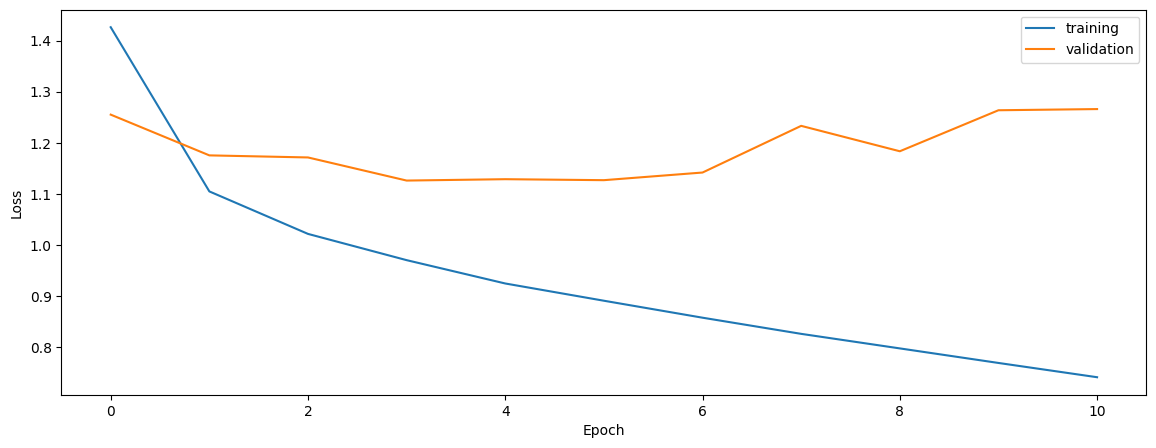

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.6340349162904099
0.5524139530090684
0.6153889237386863


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('normalized')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

normalized
0.5804807821772949
0.5552307206068268
0.5466891837229998


In [9]:
print('native')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

native
0.5782442571821784
0.5642383209207854
0.5573774121763007


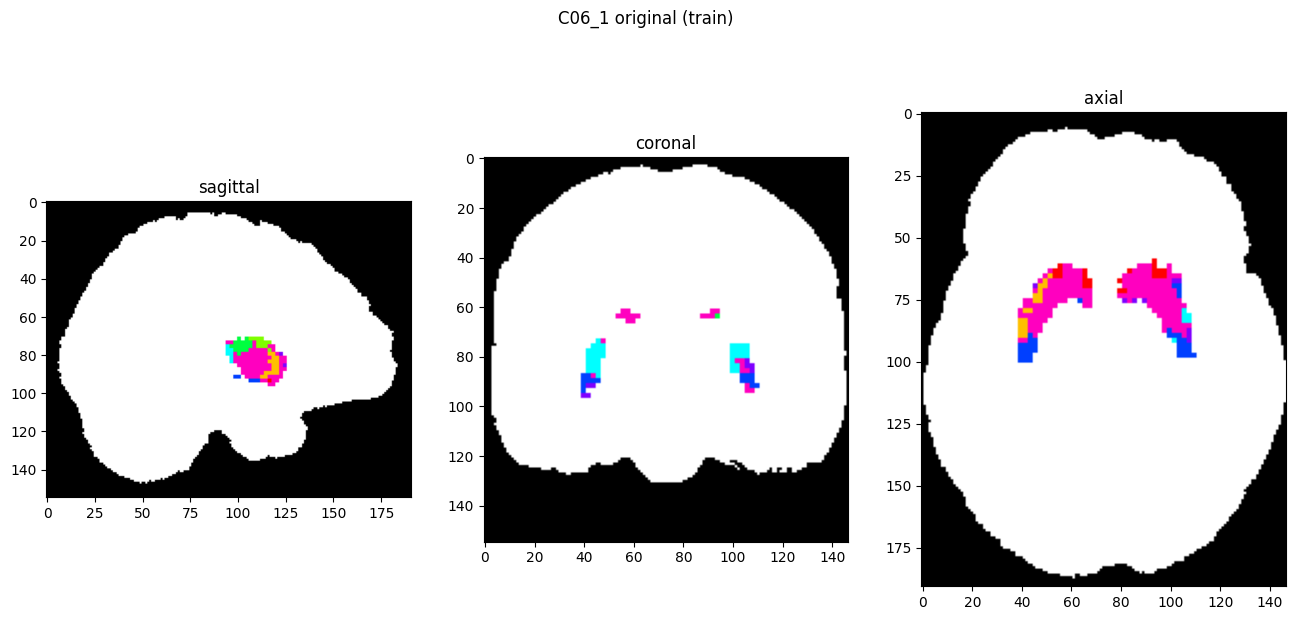

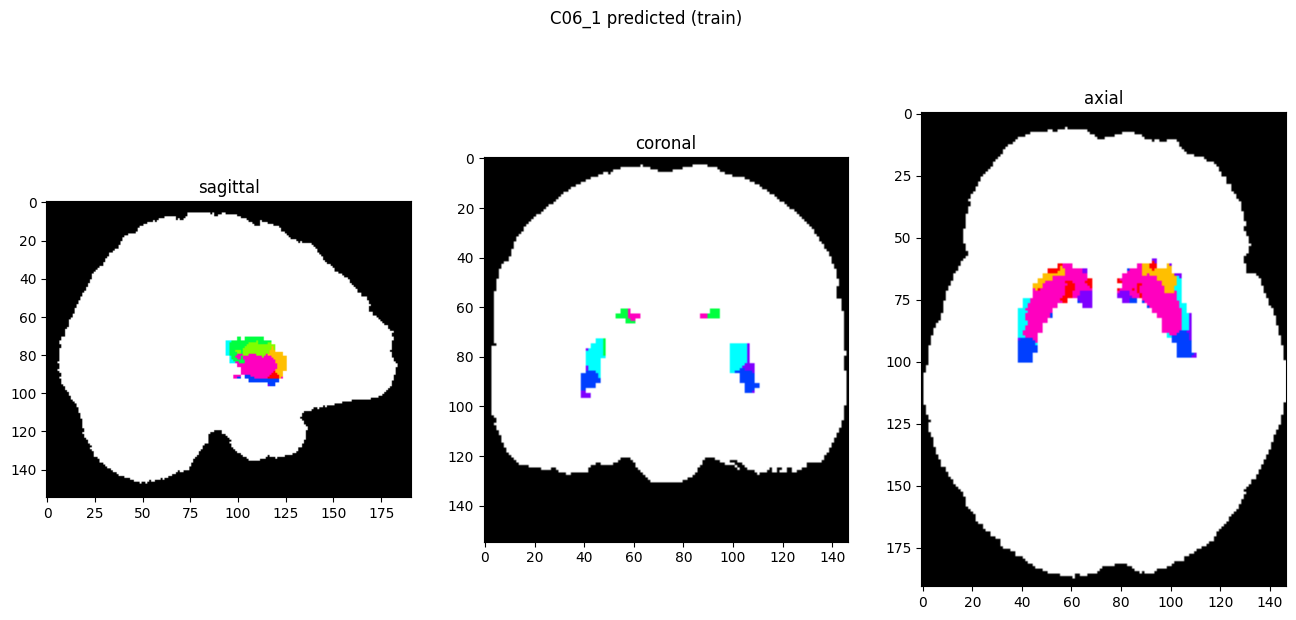

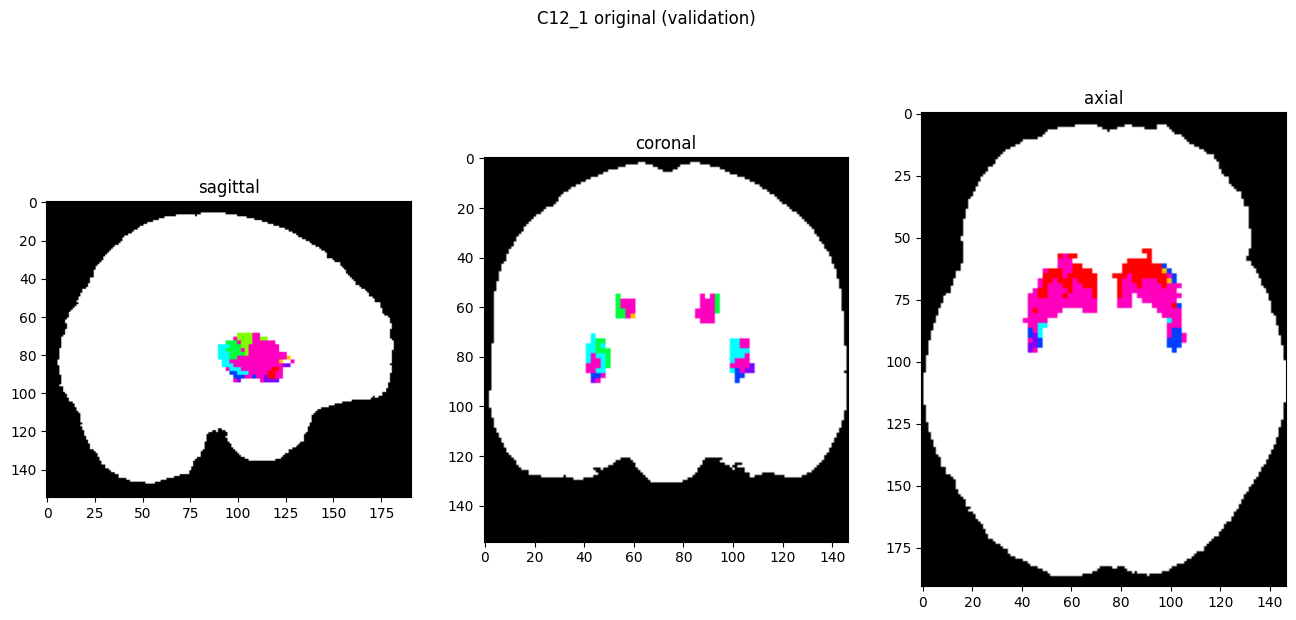

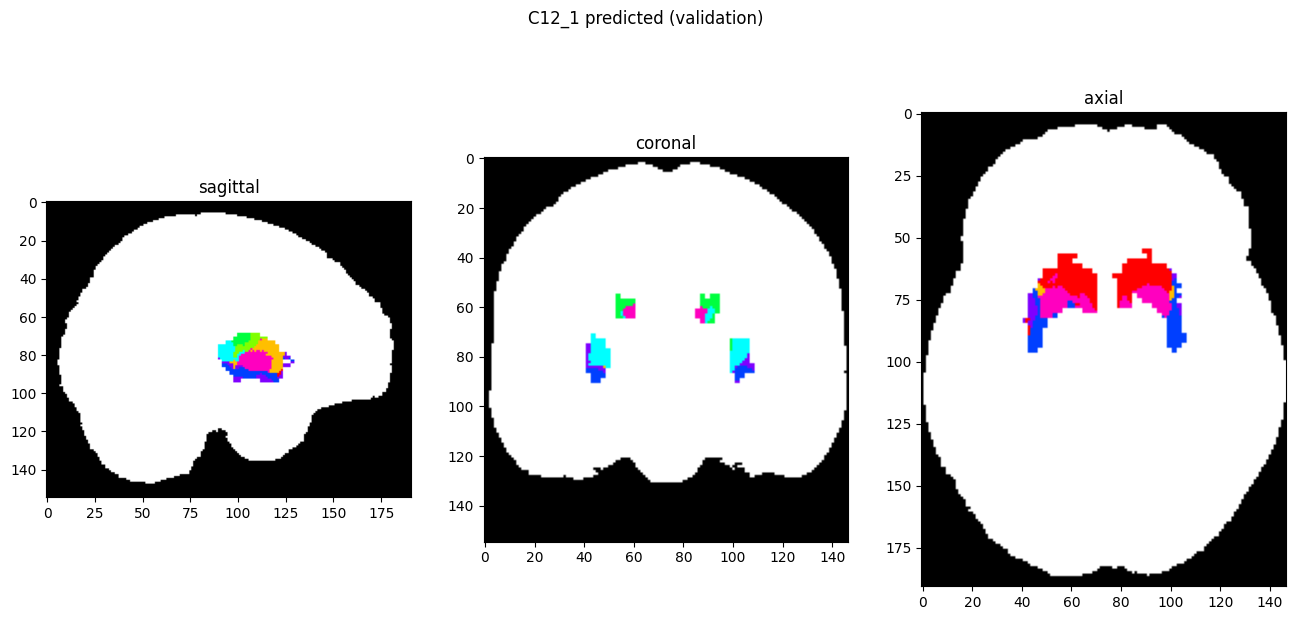

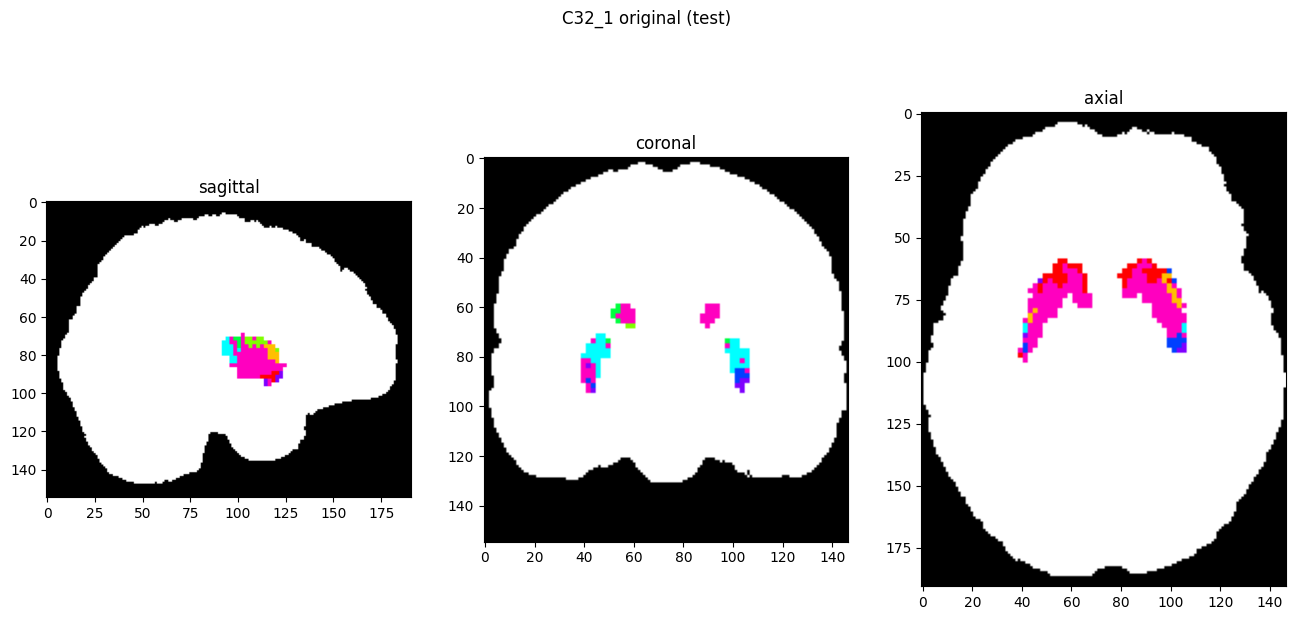

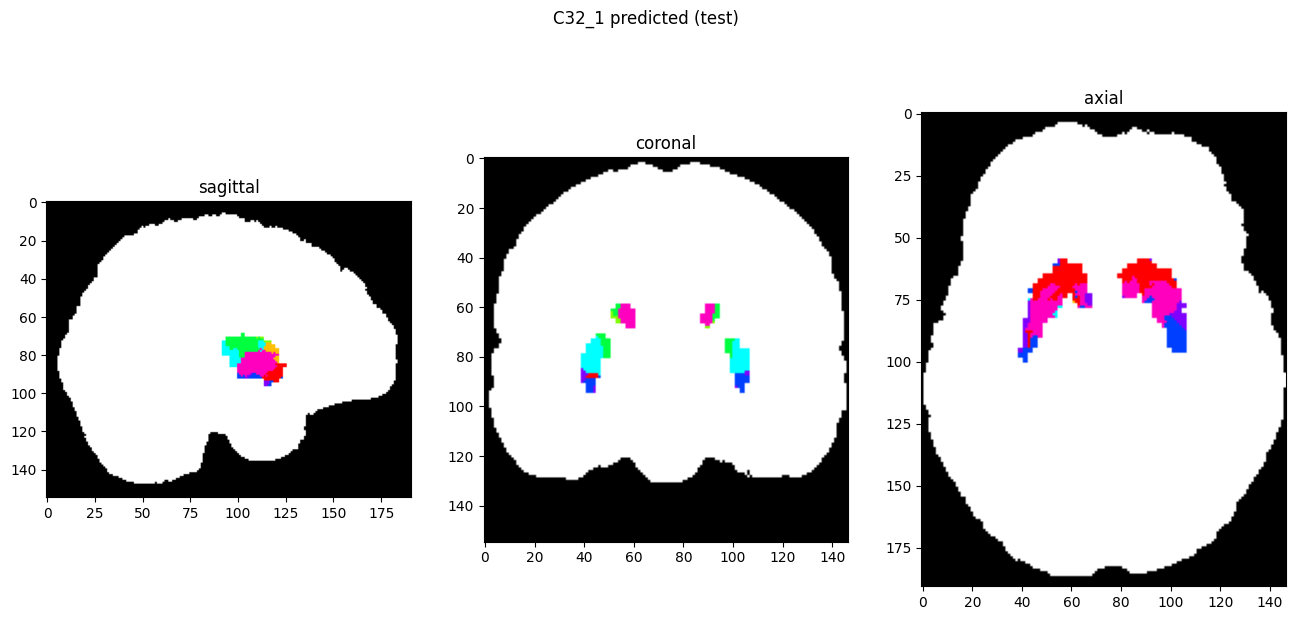

In [10]:
showResults(model, gen, threshold=0)